In [3]:
# %%bash

# mkdir -p ~/aiffel/mpii
# ln -s ~/data/* ~/aiffel/mpii
# cd ~/aiffel/mpii
# tar -xvf mpii_human_pose_v1.tar.gz -C . 
# unzip mpii_human_pose_v1_u12_2.zip

In [4]:
# %%bash

# cd ~/aiffel/mpii/mpii_human_pose_v1_u12_2
# wget https://d3s0tskafalll9.cloudfront.net/media/documents/train.json
# wget https://d3s0tskafalll9.cloudfront.net/media/documents/validation.json

In [5]:
# !cd ~/aiffel/mpii && unzip mpii.zip

# 학습 목표
Pose estimation 모델을 학습시키기 위한 데이터셋을 확보할 수 있습니다.
학습 데이터를 빠르게 읽게 하기 위한 TFRecord 형태를 이해하고 활용할 수 있습니다.
TFRecord 형태로 저장된 데이터를 모델 학습에 맞게 전처리 시킬 수 있습니다.
Stacked Hourglass Network를 구현할 수 있습니다.

# 학습 내용

- 데이터 전처리하기  
json 파일의 구성을 파악하고, 파싱하는 함수를 구현해봅시다.
- TFRecord 파일 만들기  
학습 데이터를 더 빠르게 읽게 하기 위한 TFRecord 형태로 표현하는 방법을 배워봅니다.
- Ray  
병렬 처리를 위한 라이브러리인 Ray에 대해 공부해보아요.
- data label로 만들기  
TFRecord로 저장된 데이터를 모델 학습에 필요한 데이터로 전처리하는 방법을 학습해봅시다.
- 모델을 학습해보자  
Hourglass 모델의 구조를 복습하고, 모델을 직접 구현해봅니다.
- 학습 엔진 만들기  
GPU가 여러 개이고 데이터를 병렬로 학습시키는 방법에 대해 공부해보아요.
- 둠칫둠칫 댄스타임  
학습이 끝난 모델의 inference 파이프라인을 구축해봅시다.

## 데이터 전처리하기  
json 파일의 구성을 파악하고, 파싱하는 함수를 구현해봅시다.

In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models') 
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

슝=3


In [2]:
MODEL_PATH = os.path.join(PROJECT_PATH, 'my_models')

In [5]:
# json 파싱하기
# train.json, validation.json파일의 pose keypoint정보들을 학습 이미지의 label로 사용하기 위함.

# 1개의 정보 샘플로 출력
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)
    
'''
joints_vis : 모든 label이 이미지 내 나타나지 않아서 실제로 사용할 수 있는 keypoint여부를 표기
데이터셋에 따라 occlusion까지 고려되어 있음

occlusion(폐색) - 사람이 사람 혹은 다른 객체에 의해 가려지는 현상임.
https://eehoeskrap.tistory.com/466
'''

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


'\njoints_vis : 모든 label이 이미지 내 나타나지 않아서 실제로 사용할 수 있는 keypoint여부를 표기\n데이터셋에 따라 occlusion까지 고려되어 있음\n\nocclusion(폐색) - 사람이 사람 혹은 다른 객체에 의해 가려지는 현상임.\nhttps://eehoeskrap.tistory.com/466\n'

### joints의 순서
    0 - 오른쪽 발목
    1 - 오른쪽 무릎
    2 - 오른쪽 엉덩이
    3 - 왼쪽 엉덩이
    4 - 왼쪽 무릎
    5 - 왼쪽 발목
    6 - 골반
    7 - 가슴(흉부)
    8 - 목
    9 - 머리 위
    10 - 오른쪽 손목
    11 - 오른쪽 팔꿈치
    12 - 오른쪽 어깨
    13 - 왼쪽 어깨
    14 - 왼쪽 팔꿈치
    15 - 왼쪽 손목

### scale, center
    scale과 center는 사람 몸의 크기와 중심점. 
    이미지의 크기에 따라 관절의 좌표가 상대적으로 바뀌기 때문에 이를 보정하기 위함.
    scale은 200을 곱해야 온전한 크기가 됩니다. 
    추후에 전처리 과정에서 200을 곱해서 사용할 예정

In [3]:
# 1개의 json annotation을 파싱
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


In [7]:
# 파싱 기능 테스트
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


## TFRecord 파일 만들기  
학습 데이터를 더 빠르게 읽게 하기 위한 TFRecord 형태로 표현하는 방법을 배워봅니다.

#### ImageDataGenerator 대신 TFRecord를 사용하는 이유 : 
> 큰 크기의 데이터셋 로드에 따른 학습의 병목을 막기 위함.   
> GPU의 연산이 HDD I/O보다 더 빠를 때 발생

In [4]:
# 추출한 annotation을 TFRecord로 변환하는 함수
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        # value가 tensor인지 확인하고 텐서라면 numpy로 변환
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        # numpy를 ByteList로 변환
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    # 파일 읽기
    ## 어노테이션(anno)에서 파일이름과 경로를 불러옴
    filename = anno['filename']
    filepath = anno['filepath']

    # 이미지 파일을 binary로 열기
    with open(filepath, 'rb') as image_file:
        content = image_file.read()
    
    # 이미지 열기
    image = Image.open(filepath)
    # 이미지 포멧 및 모드를 확인
    if image.format != 'JPEG' or image.mode != 'RGB': # JPEG/RGB인지 확인하고

        # 아닌 경우에 RGB변환을 진행 후 JPEG로 저장
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            # binary 데이터로 content 갱신
            content = output.getvalue()

    # 이미지 크기, 채널 수 설정
    width, height = image.size
    depth = 3
    
    # 어노테이션 데이터 변환
    # 중심 좌표
    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    # 스케일
    scale = anno['scale']
    
    # 관절 좌표를 x, y로 분리 후 리스트로 저장
    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    
    # 관절 가시성을 0, 2로 변환 후 저장
    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]
    
    # TFRecord 변환을 위해 tf.train.Feature 변환된 개별 값이 모인 딕셔너리(feature)로 저장
    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }
    
    # tf.train.Example의 형태로 변환하여 반환
    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


In [5]:
# 얼마나 많은 TFRecord를 만들지 결정하는 함수
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')
# 전체 데이터를 '몇개의 그룹'으로 나눌 지 결정
# 전체 데이터 l을 n그룹으로 나눈다. -> 결과적으로 n개의 TFRecord 파일을 생성
# "n개로 shard"했다. 
# 기업에서 매우 크고 여러 장비에 데이터가 나뉘어있어서 "sharding"한다고 한다.
# 데이터 저장과 병렬처리에 이점이있다.

슝=3


- 어떤 데이터셋이 있는지, 어떻게 변환되었는지를 중점으로 확인하기

In [10]:
# 1000개의 데이터를 64개의 TFRecord로 생성한다. 
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0])) # 개별 TFRecord에는 15개의 값을 가지고 있다. 

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

### Ray 
- multiprocessing패키지보다 다양한 환경에서 사용할 수 있는 병렬처리 라이브러리

In [6]:
# 하나의 chunk를 TFRecord로 만들어 줄 함수
@ray.remote # 병렬 처리 추가된 코드
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


In [7]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures) # 병렬 처리 추가된 코드

print('슝=3')

슝=3


## Ray  
병렬 처리를 위한 라이브러리인 Ray에 대해 공부해보아요.

- 쓰던 코드에서 수정 없이 병렬화가 가능
- ray.init(), ray.remote(), ray.get()만을 추가

- 처음 1회만 생성하면 된다.

In [13]:
# num_train_shards = 64
# num_val_shards = 8

# ray.init() # 병렬 처리 추가된 코드

# print('Start to parse annotations.')
# if not os.path.exists(TFRECORD_PATH):
#     os.makedirs(TFRECORD_PATH)

# with open(TRAIN_JSON) as train_json:
#     train_annos = json.load(train_json)
#     train_annotations = [
#         parse_one_annotation(anno, IMAGE_PATH)
#         for anno in train_annos
#     ]
#     print('First train annotation: ', train_annotations[0])

# with open(VALID_JSON) as val_json:
#     val_annos = json.load(val_json)
#     val_annotations = [
#         parse_one_annotation(anno, IMAGE_PATH) 
#         for anno in val_annos
#     ]
#     print('First val annotation: ', val_annotations[0])
    
# print('Start to build TF Records.')
# build_tf_records(train_annotations, num_train_shards, 'train')
# build_tf_records(val_annotations, num_val_shards, 'val')

# print('Successfully wrote {} annotations to TF Records.'.format(
#     len(train_annotations) + len(val_annotations)))

2024-07-19 02:24:08,953	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.78gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

KeyboardInterrupt: 

- 예시 코드
```python
import ray
ray.init()
@ray.remote
def f(x):
    return x * x
futures = [f.remote(i) for i in range(4)]
print(ray.get(futures)) # [0, 1, 4, 9]
@ray.remote
class Counter(object):
    def __init__(self):
        self.n = 0

    def increment(self):
        self.n += 1

    def read(self):
        return self.n
counters = [Counter.remote() for i in range(4)]
[c.increment.remote() for c in counters]
futures = [c.read.remote() for c in counters]
print(ray.get(futures)) # [1, 1, 1, 1]
```

- 함수, 클래스에 `@ray.remote`를 붙여서 사용하고
- `some_function.remote()`로 함수, 클래스의 인스턴스를 생성

- 이 시점에 생성만 되는 것이고, `ray.get()`이 호출될 때 비로소 실행 됨

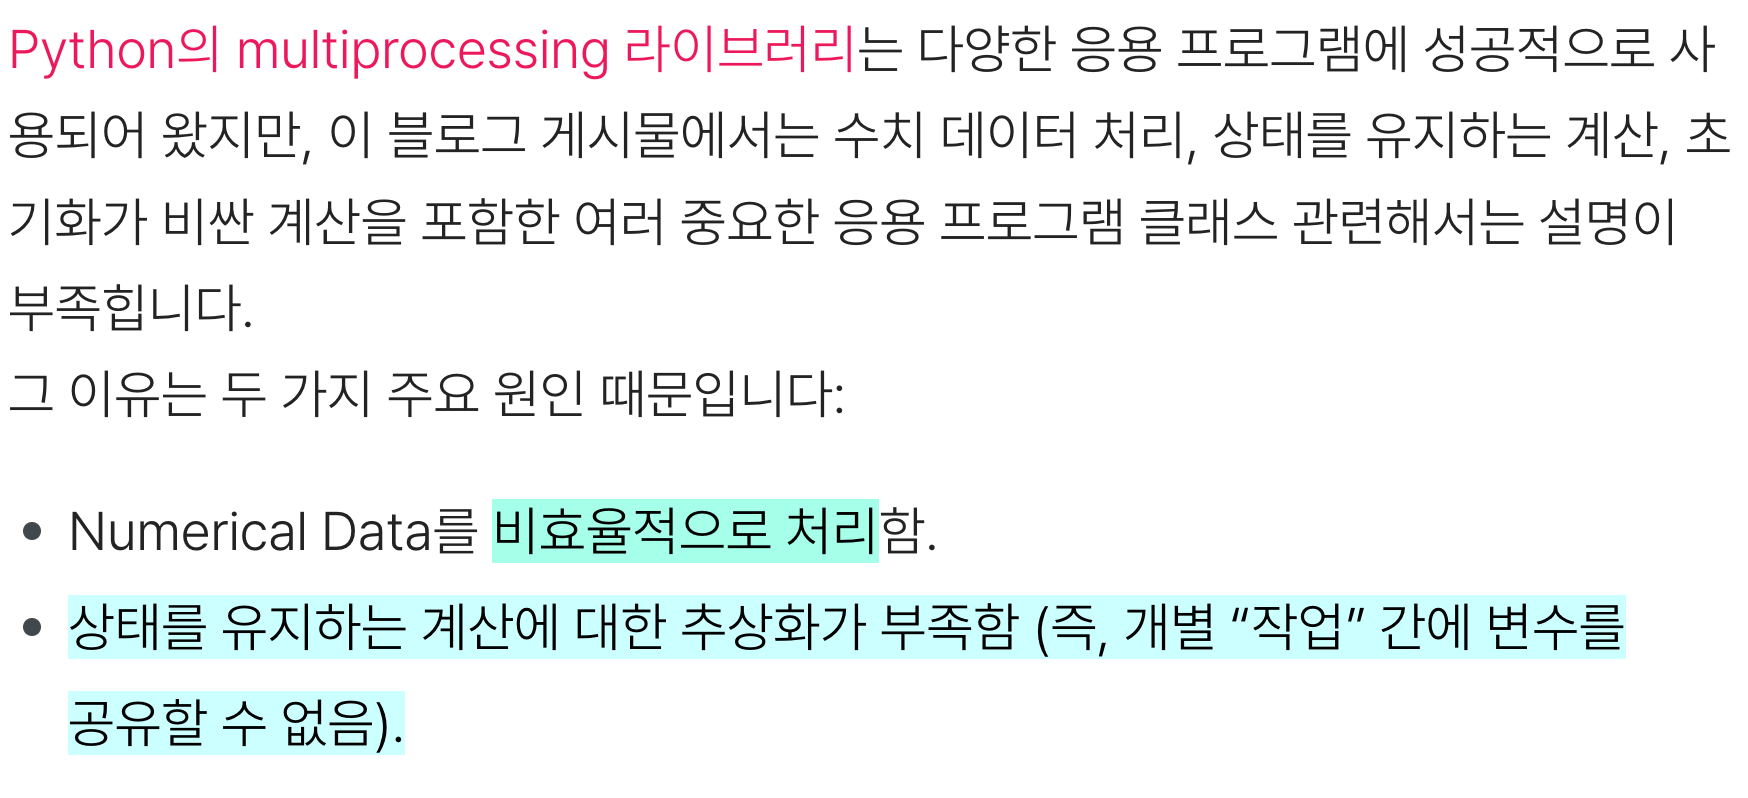
https://modulabs.co.kr/blog/ray-multiprocessing-python/

- Ray를 사용하여 빠르고 간단한 분산 응용 프로그램을 구축 가능
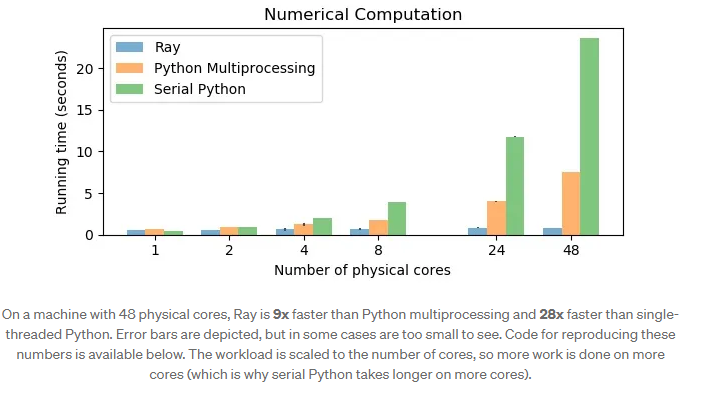
    단일 스레드보다 10-30배, multiprocessing보다 5-25배 빠르다.
    머신이 커질 경우 5-25배까지 가속된다.

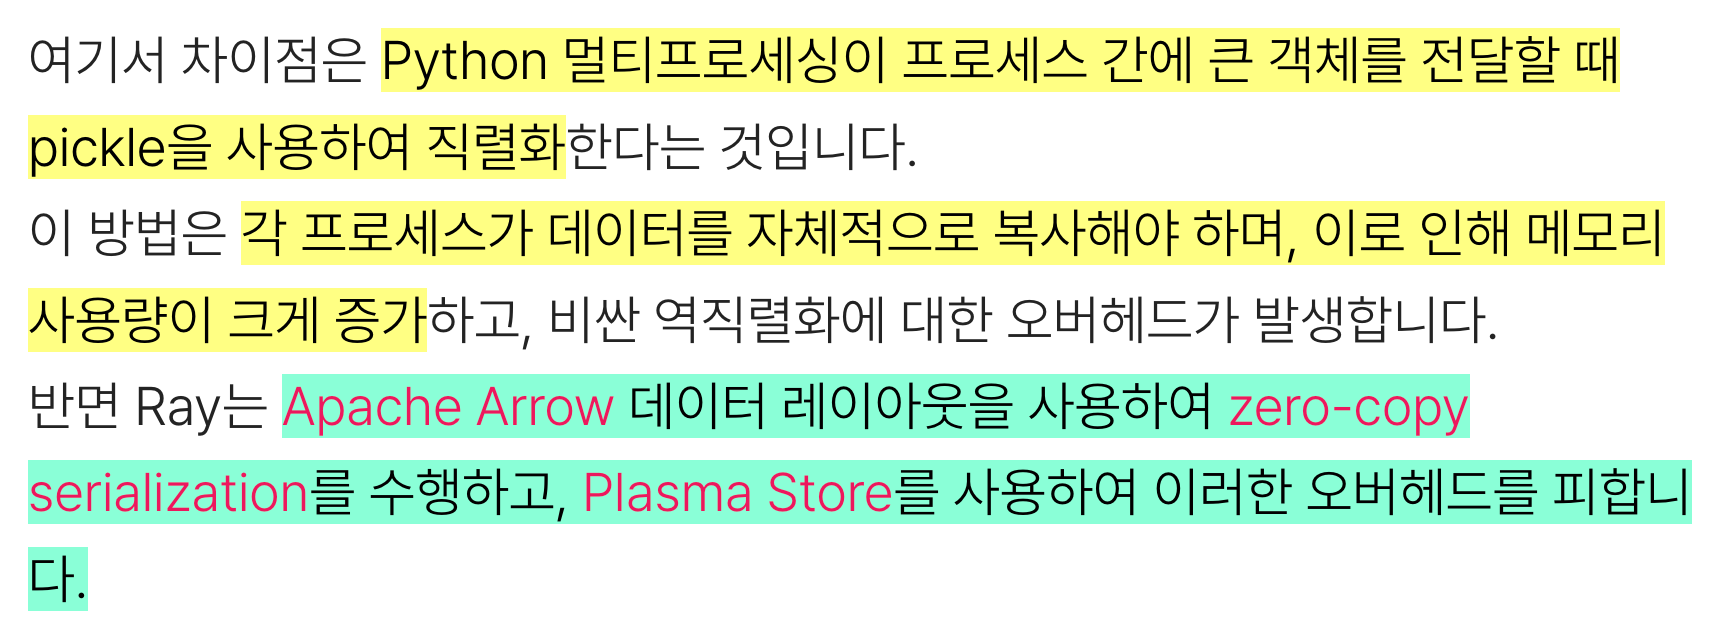
- Apache Arrow : 현대 하드웨어에서 효율적 분석 작업을 위해 설계된 언어-독립적 컬럼형 메모리 포멧, 직렬화 오버헤드 없이 빠른 데이터 액세스를 위한 zero-copy Serialization을 지원
- zero-copy Serialization : 공유 메모리에 저장되어 다중 프로세스에서 카피 없이 사용할 수 있음.
- Plasma Store : Plasma는 Apach Arrow의 일부로 인메모리 객체 저장소임. 많은 클라이언트가 효율적으로 액세스할 수 있도록 공유메모리에 불변 객체를 보관함. 여러 프레임워크 간 zero-copy 데이터 교환을 가능하게 하는 공통 데이터 레이어.

## data label로 만들기  
TFRecord로 저장된 데이터를 모델 학습에 필요한 데이터로 전처리하는 방법을 학습해봅시다.

In [ ]:
# def parse_tfexample(example):
#     image_feature_description = {
#         'image/height': tf.io.FixedLenFeature([], tf.int64),
#         'image/width': tf.io.FixedLenFeature([], tf.int64),
#         'image/depth': tf.io.FixedLenFeature([], tf.int64),
#         'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
#         'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
#         'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
#         'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
#         'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
#         'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
#         'image/encoded': tf.io.FixedLenFeature([], tf.string),
#         'image/filename': tf.io.FixedLenFeature([], tf.string),
#     }
#     return tf.io.parse_single_example(example, image_feature_description)

# print('슝=3')

In [ ]:
# # 적당한 정사각형으로 crop하여 사용하는 함수
# def crop_roi(image, features, margin=0.2):
#     img_shape = tf.shape(image)
#     img_height = img_shape[0]
#     img_width = img_shape[1]
#     img_depth = img_shape[2]

#     keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
#     keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
#     center_x = features['image/object/center/x']
#     center_y = features['image/object/center/y']
#     body_height = features['image/object/scale'] * 200.0

#     # keypoint 중 유효한값(visible = 1) 만 사용합니다.
#     masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
#     masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

#     # min, max 값을 찾습니다.
#     keypoint_xmin = tf.reduce_min(masked_keypoint_x)
#     keypoint_xmax = tf.reduce_max(masked_keypoint_x)
#     keypoint_ymin = tf.reduce_min(masked_keypoint_y)
#     keypoint_ymax = tf.reduce_max(masked_keypoint_y)

#     # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
#     xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
#     xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
#     ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
#     ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

#     # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
#     effective_xmin = xmin if xmin > 0 else 0
#     effective_ymin = ymin if ymin > 0 else 0
#     effective_xmax = xmax if xmax < img_width else img_width
#     effective_ymax = ymax if ymax < img_height else img_height
#     effective_height = effective_ymax - effective_ymin
#     effective_width = effective_xmax - effective_xmin

#     image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
#     new_shape = tf.shape(image)
#     new_height = new_shape[0]
#     new_width = new_shape[1]

#     effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
#     effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

#     return image, effective_keypoint_x, effective_keypoint_y

# print('슝=3')

In [ ]:
# # 가우시안 생성
# def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
#     heatmap = tf.zeros((height, width))

#     xmin = x0 - 3 * sigma
#     ymin = y0 - 3 * sigma
#     xmax = x0 + 3 * sigma
#     ymax = y0 + 3 * sigma
    
#     if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
#         return heatmap

#     size = 6 * sigma + 1
#     x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

#     center_x = size // 2
#     center_y = size // 2

#     gaussian_patch = tf.cast(tf.math.exp(
#         -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
#                              dtype=tf.float32)

#     patch_xmin = tf.math.maximum(0, -xmin)
#     patch_ymin = tf.math.maximum(0, -ymin)
#     patch_xmax = tf.math.minimum(xmax, width) - xmin
#     patch_ymax = tf.math.minimum(ymax, height) - ymin

#     heatmap_xmin = tf.math.maximum(0, xmin)
#     heatmap_ymin = tf.math.maximum(0, ymin)
#     heatmap_xmax = tf.math.minimum(xmax, width)
#     heatmap_ymax = tf.math.minimum(ymax, height)

#     indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
#     updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

#     count = 0

#     for j in tf.range(patch_ymin, patch_ymax):
#         for i in tf.range(patch_xmin, patch_xmax):
#             indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
#             updates = updates.write(count, gaussian_patch[j][i])
#             count += 1

#     heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

#     return heatmap

In [8]:
# # 히트맵 생성
# def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
#     v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
#     x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
#     y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

#     num_heatmap = heatmap_shape[2]
#     heatmap_array = tf.TensorArray(tf.float32, 16)

#     for i in range(num_heatmap):
#         gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
#         heatmap_array = heatmap_array.write(i, gaussian)

#     heatmaps = heatmap_array.stack()
#     heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

#     return heatmaps

# print('슝=3')

In [8]:
# 전처리 클래스 객체의 형태로 조합
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


## 모델을 학습해보자  
Hourglass 모델의 구조를 복습하고, 모델을 직접 구현해봅니다.

## Hourglass model만들기
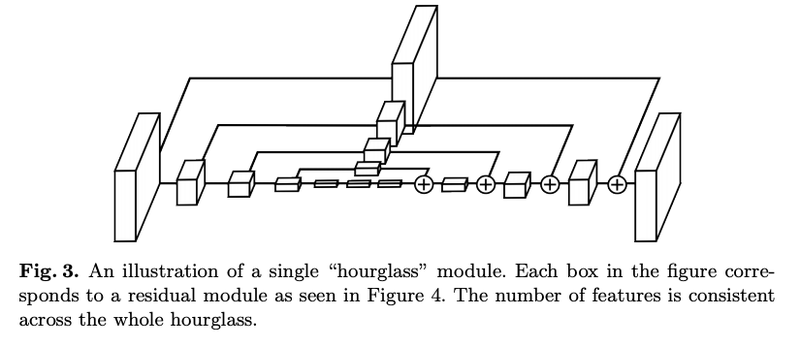

- Residual block의 2가지 타임
1. 3x3 - 3x3 basic block
2. 1x1 - 3x3 - 1x1 bottleneck block

In [9]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


In [10]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


In [11]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


In [12]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


## 학습 엔진 만들기  
GPU가 여러 개이고 데이터를 병렬로 학습시키는 방법에 대해 공부해보아요.

In [19]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


### 분산전략
    MirroredStrategy : TensorFlow에서 다중 GPU 환경에서 모델을 훈련하기 위한 분산 전략

    TPUStrategy : 구글의 Tensor Processing Units(TPU)를 사용하여 모델을 훈련하기 위한 분산 전략

    MultiWorkerMirroredStrategy : 다중 워커(worker) 환경에서 모델을 훈련하기 위한 분산 전략

    ParameterServerStrategy : 다중 서버(server) 환경에서 모델을 훈련하기 위한 분산 전략

    CentralStorageStrategy : 중앙 저장소를 사용하여 모델을 훈련하기 위한 분산 전략

In [14]:
# 데이터셋 만드는 함수
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

슝=3


In [16]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope(): # 분산학습에서의 필요한 것
        # 분산된 데이터셋에 대한 연결 : experimental_distribute_dataset
        train_dist_dataset = strategy.experimental_distribute_dataset( 
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3


In [22]:
%%time
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')

# Constants for hyperparameters
epochs = 1
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

(build_single_tfrecord pid=183) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0017_of_0064.tfrecords
(build_single_tfrecord pid=183) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0020_of_0064.tfrecords
(build_single_tfrecord pid=184) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0018_of_0064.tfrecords
(build_single_tfrecord pid=184) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0021_of_0064.tfrecords
(build_single_tfrecord pid=182) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0019_of_0064.tfrecords
(build_single_tfrecord pid=182) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0022_of_0064.tfrecords
(build_single_tfrecord pid=183) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0020_of_0064.tfrecords
(build_single_tfrecord pid=183) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_002

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


(build_single_tfrecord pid=184) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=184) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0031_of_0064.tfrecords
(build_single_tfrecord pid=182) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=182) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0032_of_0064.tfrecords
(build_single_tfrecord pid=183) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=183) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0033_of_0064.tfrecords
(build_single_tfrecord pid=182) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0032_of_0064.tfrecords
(build_single_tfrecord pid=182) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_003

(build_single_tfrecord pid=182) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=182) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0060_of_0064.tfrecords
(build_single_tfrecord pid=183) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=183) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0061_of_0064.tfrecords
(build_single_tfrecord pid=184) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=184) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0062_of_0064.tfrecords
(build_single_tfrecord pid=183) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0061_of_0064.tfrecords
(build_single_tfrecord pid=183) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

Trained batch 97 batch loss 1.79934919 epoch total loss 1.80049264
Trained batch 98 batch loss 1.67491138 epoch total loss 1.79921114
Trained batch 99 batch loss 1.52131832 epoch total loss 1.79640412
Trained batch 100 batch loss 1.45971823 epoch total loss 1.7930373
Trained batch 101 batch loss 1.51969576 epoch total loss 1.79033089
Trained batch 102 batch loss 1.70891809 epoch total loss 1.78953278
Trained batch 103 batch loss 1.61552143 epoch total loss 1.78784347
Trained batch 104 batch loss 1.54701591 epoch total loss 1.78552771
Trained batch 105 batch loss 1.51450682 epoch total loss 1.78294659
Trained batch 106 batch loss 1.64384663 epoch total loss 1.78163433
Trained batch 107 batch loss 1.5577414 epoch total loss 1.77954185
Trained batch 108 batch loss 1.55056858 epoch total loss 1.77742171
Trained batch 109 batch loss 1.67651653 epoch total loss 1.77649593
Trained batch 110 batch loss 1.52707362 epoch total loss 1.77422845
Trained batch 111 batch loss 1.70878339 epoch total l

Trained batch 219 batch loss 1.70328391 epoch total loss 1.71121085
Trained batch 220 batch loss 1.73293388 epoch total loss 1.71130967
Trained batch 221 batch loss 1.74137306 epoch total loss 1.71144569
Trained batch 222 batch loss 1.75519538 epoch total loss 1.71164274
Trained batch 223 batch loss 1.7721982 epoch total loss 1.71191418
Trained batch 224 batch loss 1.665941 epoch total loss 1.71170902
Trained batch 225 batch loss 1.5597403 epoch total loss 1.7110337
Trained batch 226 batch loss 1.59579706 epoch total loss 1.71052372
Trained batch 227 batch loss 1.68413818 epoch total loss 1.7104075
Trained batch 228 batch loss 1.62934911 epoch total loss 1.71005213
Trained batch 229 batch loss 1.60874796 epoch total loss 1.70960963
Trained batch 230 batch loss 1.72067308 epoch total loss 1.70965779
Trained batch 231 batch loss 1.64017868 epoch total loss 1.7093569
Trained batch 232 batch loss 1.62006092 epoch total loss 1.70897198
Trained batch 233 batch loss 1.59443569 epoch total los

Trained batch 341 batch loss 1.47071683 epoch total loss 1.67822933
Trained batch 342 batch loss 1.57487357 epoch total loss 1.67792714
Trained batch 343 batch loss 1.62385106 epoch total loss 1.67776942
Trained batch 344 batch loss 1.6203202 epoch total loss 1.67760241
Trained batch 345 batch loss 1.61820567 epoch total loss 1.67743027
Trained batch 346 batch loss 1.5686357 epoch total loss 1.67711592
Trained batch 347 batch loss 1.6096344 epoch total loss 1.67692137
Trained batch 348 batch loss 1.61857057 epoch total loss 1.67675376
Trained batch 349 batch loss 1.53750539 epoch total loss 1.67635465
Trained batch 350 batch loss 1.54377723 epoch total loss 1.67597592
Trained batch 351 batch loss 1.59874463 epoch total loss 1.67575586
Trained batch 352 batch loss 1.6222769 epoch total loss 1.67560387
Trained batch 353 batch loss 1.59364724 epoch total loss 1.67537165
Trained batch 354 batch loss 1.54110742 epoch total loss 1.67499244
Trained batch 355 batch loss 1.6570642 epoch total l

Trained batch 463 batch loss 1.51693988 epoch total loss 1.65966022
Trained batch 464 batch loss 1.50206256 epoch total loss 1.65932059
Trained batch 465 batch loss 1.3104527 epoch total loss 1.65857029
Trained batch 466 batch loss 1.44187367 epoch total loss 1.65810525
Trained batch 467 batch loss 1.52601385 epoch total loss 1.65782237
Trained batch 468 batch loss 1.35270131 epoch total loss 1.65717053
Trained batch 469 batch loss 1.26215076 epoch total loss 1.6563282
Trained batch 470 batch loss 1.32949722 epoch total loss 1.65563273
Trained batch 471 batch loss 1.39735079 epoch total loss 1.65508437
Trained batch 472 batch loss 1.50851631 epoch total loss 1.65477395
Trained batch 473 batch loss 1.52555776 epoch total loss 1.65450072
Trained batch 474 batch loss 1.64343429 epoch total loss 1.65447736
Trained batch 475 batch loss 1.63745403 epoch total loss 1.6544416
Trained batch 476 batch loss 1.64995682 epoch total loss 1.65443218
Trained batch 477 batch loss 1.62464511 epoch total

Trained batch 585 batch loss 1.34587061 epoch total loss 1.6296804
Trained batch 586 batch loss 1.53729367 epoch total loss 1.6295228
Trained batch 587 batch loss 1.52269 epoch total loss 1.62934077
Trained batch 588 batch loss 1.51498461 epoch total loss 1.62914634
Trained batch 589 batch loss 1.55827487 epoch total loss 1.62902606
Trained batch 590 batch loss 1.59716165 epoch total loss 1.62897205
Trained batch 591 batch loss 1.6034652 epoch total loss 1.6289289
Trained batch 592 batch loss 1.59076977 epoch total loss 1.62886441
Trained batch 593 batch loss 1.40230227 epoch total loss 1.62848234
Trained batch 594 batch loss 1.63081241 epoch total loss 1.62848616
Trained batch 595 batch loss 1.6160388 epoch total loss 1.62846529
Trained batch 596 batch loss 1.54931 epoch total loss 1.6283325
Trained batch 597 batch loss 1.46179199 epoch total loss 1.62805355
Trained batch 598 batch loss 1.51611745 epoch total loss 1.62786627
Trained batch 599 batch loss 1.41407239 epoch total loss 1.6

Trained batch 707 batch loss 1.59046483 epoch total loss 1.61591363
Trained batch 708 batch loss 1.50684834 epoch total loss 1.61575961
Trained batch 709 batch loss 1.54250968 epoch total loss 1.61565626
Trained batch 710 batch loss 1.55739427 epoch total loss 1.61557412
Trained batch 711 batch loss 1.50396967 epoch total loss 1.61541724
Trained batch 712 batch loss 1.46245718 epoch total loss 1.61520231
Trained batch 713 batch loss 1.48442054 epoch total loss 1.61501884
Trained batch 714 batch loss 1.47908056 epoch total loss 1.61482847
Trained batch 715 batch loss 1.5149107 epoch total loss 1.61468875
Trained batch 716 batch loss 1.55103695 epoch total loss 1.61459982
Trained batch 717 batch loss 1.56285429 epoch total loss 1.6145277
Trained batch 718 batch loss 1.55318236 epoch total loss 1.61444223
Trained batch 719 batch loss 1.58758509 epoch total loss 1.6144048
Trained batch 720 batch loss 1.57957077 epoch total loss 1.61435652
Trained batch 721 batch loss 1.51039517 epoch total

Trained batch 828 batch loss 1.26431978 epoch total loss 1.599859
Trained batch 829 batch loss 1.44476724 epoch total loss 1.59967196
Trained batch 830 batch loss 1.63005412 epoch total loss 1.59970856
Trained batch 831 batch loss 1.46735394 epoch total loss 1.59954929
Trained batch 832 batch loss 1.53276014 epoch total loss 1.59946895
Trained batch 833 batch loss 1.49965048 epoch total loss 1.59934914
Trained batch 834 batch loss 1.50382924 epoch total loss 1.59923458
Trained batch 835 batch loss 1.54292464 epoch total loss 1.59916711
Trained batch 836 batch loss 1.44429564 epoch total loss 1.59898198
Trained batch 837 batch loss 1.31067371 epoch total loss 1.59863746
Trained batch 838 batch loss 1.50697827 epoch total loss 1.59852803
Trained batch 839 batch loss 1.50900924 epoch total loss 1.59842145
Trained batch 840 batch loss 1.42894793 epoch total loss 1.59821963
Trained batch 841 batch loss 1.50254071 epoch total loss 1.59810591
Trained batch 842 batch loss 1.5200758 epoch total

Trained batch 950 batch loss 1.53801417 epoch total loss 1.58532941
Trained batch 951 batch loss 1.45922709 epoch total loss 1.58519685
Trained batch 952 batch loss 1.5271529 epoch total loss 1.58513582
Trained batch 953 batch loss 1.53870928 epoch total loss 1.58508706
Trained batch 954 batch loss 1.55977345 epoch total loss 1.5850606
Trained batch 955 batch loss 1.41151941 epoch total loss 1.58487892
Trained batch 956 batch loss 1.48801947 epoch total loss 1.58477759
Trained batch 957 batch loss 1.50034475 epoch total loss 1.58468938
Trained batch 958 batch loss 1.40874064 epoch total loss 1.58450568
Trained batch 959 batch loss 1.37346911 epoch total loss 1.5842855
Trained batch 960 batch loss 1.44906723 epoch total loss 1.58414471
Trained batch 961 batch loss 1.46220994 epoch total loss 1.58401775
Trained batch 962 batch loss 1.51345444 epoch total loss 1.58394444
Trained batch 963 batch loss 1.53612483 epoch total loss 1.58389473
Trained batch 964 batch loss 1.31618845 epoch total

Trained batch 1071 batch loss 1.42888069 epoch total loss 1.5725832
Trained batch 1072 batch loss 1.43137527 epoch total loss 1.57245147
Trained batch 1073 batch loss 1.43012273 epoch total loss 1.57231891
Trained batch 1074 batch loss 1.35758352 epoch total loss 1.57211888
Trained batch 1075 batch loss 1.43972182 epoch total loss 1.57199574
Trained batch 1076 batch loss 1.36472285 epoch total loss 1.57180309
Trained batch 1077 batch loss 1.38307548 epoch total loss 1.57162786
Trained batch 1078 batch loss 1.46952963 epoch total loss 1.57153308
Trained batch 1079 batch loss 1.47124517 epoch total loss 1.5714401
Trained batch 1080 batch loss 1.55829608 epoch total loss 1.57142794
Trained batch 1081 batch loss 1.60017717 epoch total loss 1.57145464
Trained batch 1082 batch loss 1.65336442 epoch total loss 1.57153022
Trained batch 1083 batch loss 1.50531793 epoch total loss 1.57146919
Trained batch 1084 batch loss 1.45145094 epoch total loss 1.57135844
Trained batch 1085 batch loss 1.4391

Trained batch 1191 batch loss 1.39728522 epoch total loss 1.5608983
Trained batch 1192 batch loss 1.38826549 epoch total loss 1.56075358
Trained batch 1193 batch loss 1.2902056 epoch total loss 1.56052673
Trained batch 1194 batch loss 1.46116865 epoch total loss 1.56044352
Trained batch 1195 batch loss 1.42333078 epoch total loss 1.56032884
Trained batch 1196 batch loss 1.55738795 epoch total loss 1.56032634
Trained batch 1197 batch loss 1.42449176 epoch total loss 1.56021273
Trained batch 1198 batch loss 1.40646172 epoch total loss 1.56008446
Trained batch 1199 batch loss 1.50572133 epoch total loss 1.56003916
Trained batch 1200 batch loss 1.39421988 epoch total loss 1.55990088
Trained batch 1201 batch loss 1.39574814 epoch total loss 1.55976427
Trained batch 1202 batch loss 1.49694204 epoch total loss 1.55971193
Trained batch 1203 batch loss 1.42500722 epoch total loss 1.5596
Trained batch 1204 batch loss 1.40368009 epoch total loss 1.55947053
Trained batch 1205 batch loss 1.52430665

Trained batch 1311 batch loss 1.29920828 epoch total loss 1.54953861
Trained batch 1312 batch loss 1.47078824 epoch total loss 1.54947865
Trained batch 1313 batch loss 1.44490314 epoch total loss 1.54939902
Trained batch 1314 batch loss 1.41280663 epoch total loss 1.54929519
Trained batch 1315 batch loss 1.35133541 epoch total loss 1.54914463
Trained batch 1316 batch loss 1.44937205 epoch total loss 1.54906869
Trained batch 1317 batch loss 1.34319401 epoch total loss 1.54891241
Trained batch 1318 batch loss 1.57971025 epoch total loss 1.54893577
Trained batch 1319 batch loss 1.4354502 epoch total loss 1.5488497
Trained batch 1320 batch loss 1.50799358 epoch total loss 1.54881871
Trained batch 1321 batch loss 1.36440849 epoch total loss 1.54867911
Trained batch 1322 batch loss 1.52783215 epoch total loss 1.54866326
Trained batch 1323 batch loss 1.36542678 epoch total loss 1.54852474
Trained batch 1324 batch loss 1.36534071 epoch total loss 1.54838634
Trained batch 1325 batch loss 1.4329

Validated batch 70 batch loss 1.40472722
Validated batch 71 batch loss 1.46717107
Validated batch 72 batch loss 1.31417918
Validated batch 73 batch loss 1.42994297
Validated batch 74 batch loss 1.41852975
Validated batch 75 batch loss 1.40744376
Validated batch 76 batch loss 1.46537495
Validated batch 77 batch loss 1.51824486
Validated batch 78 batch loss 1.45437372
Validated batch 79 batch loss 1.46596956
Validated batch 80 batch loss 1.51491678
Validated batch 81 batch loss 1.4366715
Validated batch 82 batch loss 1.39250624
Validated batch 83 batch loss 1.49603176
Validated batch 84 batch loss 1.42935109
Validated batch 85 batch loss 1.45331728
Validated batch 86 batch loss 1.57615328
Validated batch 87 batch loss 1.26230121
Validated batch 88 batch loss 1.39754391
Validated batch 89 batch loss 1.34331155
Validated batch 90 batch loss 1.36900043
Validated batch 91 batch loss 1.55899274
Validated batch 92 batch loss 1.32804251
Validated batch 93 batch loss 1.32043135
Validated batch 9

OSError: Unable to create file (unable to open file: name = '/aiffel/aiffel/mpii/models/model-epoch-1-loss-1.4168.h5', errno = 30, error message = 'Read-only file system', flags = 13, o_flags = 242)

In [26]:
best_model_file # 파일이 생성되지 않았음

'/aiffel/aiffel/mpii/my_models/model-epoch-1-loss-1.4159.h5'

> 도커에서 받아오는 소프트카피 링크 경로에 권한이 없어서 에러가 뜬 것 같다. 1epoch만 테스트로 돌려보기를 잘했다.

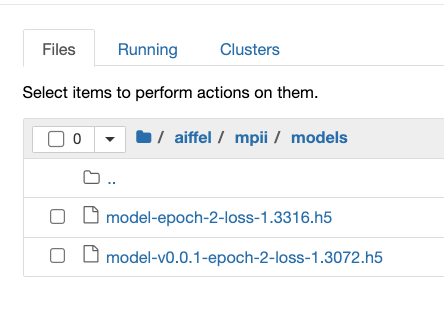
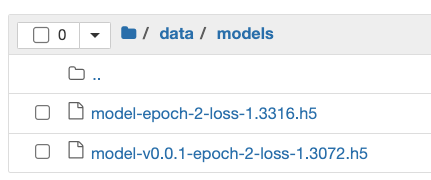
> `my_models` 경로 새로 만들고 진행
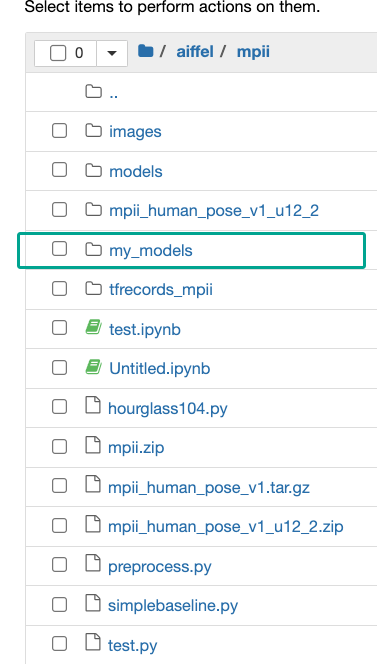

In [25]:
%%time
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')

# Constants for hyperparameters
epochs = 1
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 2.53670669 epoch total loss 2.53670669
Trained batch 2 batch loss 2.17828918 epoch total loss 2.35749793
Trained batch 3 batch loss 2.2734642 epoch total loss 2.32948661
Trained batch 4 batch loss 2.09404254 epoch total loss 2.27062559
Trained batch 5 batch loss 2.10968018 epoch total loss 2.23843646
Trained batch 6 batch loss 2.16225052 epoch total loss 2.22573876
Trained batch 7 batch loss 2.32934332 epoch total loss 2.24053955
Trained batch 8 batch loss 2.26251 epoch total loss 2.24328589
Trained batch 9 batch loss 2.24085236 epoch total loss 2.24301553
Trained batch 10 batch loss 2.22885 epoch total loss 2.24159884
Trained batch 11 batch loss 2.14574814 epoch total loss 2.23288512
Trained batch 12 batch loss 2.16746807 epoch total loss 2.22743392
Trained batch 13 batc

Trained batch 121 batch loss 1.67870009 epoch total loss 1.80905366
Trained batch 122 batch loss 1.70785785 epoch total loss 1.8082242
Trained batch 123 batch loss 1.76517534 epoch total loss 1.8078742
Trained batch 124 batch loss 1.69693518 epoch total loss 1.80697954
Trained batch 125 batch loss 1.55763936 epoch total loss 1.80498469
Trained batch 126 batch loss 1.6849041 epoch total loss 1.80403173
Trained batch 127 batch loss 1.6243335 epoch total loss 1.80261672
Trained batch 128 batch loss 1.58051217 epoch total loss 1.80088151
Trained batch 129 batch loss 1.48361492 epoch total loss 1.7984221
Trained batch 130 batch loss 1.58738756 epoch total loss 1.79679871
Trained batch 131 batch loss 1.65207326 epoch total loss 1.79569387
Trained batch 132 batch loss 1.74167109 epoch total loss 1.79528463
Trained batch 133 batch loss 1.60284138 epoch total loss 1.79383767
Trained batch 134 batch loss 1.64061713 epoch total loss 1.79269421
Trained batch 135 batch loss 1.69503224 epoch total l

Trained batch 242 batch loss 1.71051717 epoch total loss 1.71688426
Trained batch 243 batch loss 1.48774862 epoch total loss 1.71594143
Trained batch 244 batch loss 1.49888921 epoch total loss 1.71505189
Trained batch 245 batch loss 1.55405581 epoch total loss 1.71439469
Trained batch 246 batch loss 1.67488337 epoch total loss 1.71423411
Trained batch 247 batch loss 1.67573 epoch total loss 1.71407819
Trained batch 248 batch loss 1.62476921 epoch total loss 1.71371806
Trained batch 249 batch loss 1.59913301 epoch total loss 1.71325779
Trained batch 250 batch loss 1.57902288 epoch total loss 1.71272087
Trained batch 251 batch loss 1.54679227 epoch total loss 1.71205974
Trained batch 252 batch loss 1.5006659 epoch total loss 1.71122086
Trained batch 253 batch loss 1.55261898 epoch total loss 1.71059394
Trained batch 254 batch loss 1.66297424 epoch total loss 1.71040642
Trained batch 255 batch loss 1.63972569 epoch total loss 1.71012938
Trained batch 256 batch loss 1.72576678 epoch total 

Trained batch 364 batch loss 1.62509215 epoch total loss 1.67155576
Trained batch 365 batch loss 1.54275918 epoch total loss 1.6712029
Trained batch 366 batch loss 1.61995149 epoch total loss 1.67106283
Trained batch 367 batch loss 1.39452386 epoch total loss 1.67030942
Trained batch 368 batch loss 1.50010085 epoch total loss 1.66984689
Trained batch 369 batch loss 1.54888844 epoch total loss 1.66951907
Trained batch 370 batch loss 1.61702859 epoch total loss 1.66937721
Trained batch 371 batch loss 1.60537744 epoch total loss 1.66920471
Trained batch 372 batch loss 1.61514401 epoch total loss 1.66905951
Trained batch 373 batch loss 1.63806367 epoch total loss 1.66897643
Trained batch 374 batch loss 1.61401439 epoch total loss 1.66882944
Trained batch 375 batch loss 1.56415308 epoch total loss 1.66855025
Trained batch 376 batch loss 1.56994796 epoch total loss 1.66828799
Trained batch 377 batch loss 1.57694173 epoch total loss 1.66804576
Trained batch 378 batch loss 1.6617384 epoch tota

Trained batch 485 batch loss 1.64661503 epoch total loss 1.64256084
Trained batch 486 batch loss 1.58932829 epoch total loss 1.64245141
Trained batch 487 batch loss 1.63625634 epoch total loss 1.64243865
Trained batch 488 batch loss 1.60180116 epoch total loss 1.64235532
Trained batch 489 batch loss 1.59614742 epoch total loss 1.64226079
Trained batch 490 batch loss 1.56459 epoch total loss 1.64210224
Trained batch 491 batch loss 1.54896021 epoch total loss 1.64191258
Trained batch 492 batch loss 1.41775835 epoch total loss 1.64145708
Trained batch 493 batch loss 1.40776217 epoch total loss 1.64098299
Trained batch 494 batch loss 1.56308961 epoch total loss 1.64082539
Trained batch 495 batch loss 1.56945086 epoch total loss 1.64068127
Trained batch 496 batch loss 1.55767727 epoch total loss 1.6405139
Trained batch 497 batch loss 1.5820204 epoch total loss 1.64039624
Trained batch 498 batch loss 1.61421287 epoch total loss 1.64034355
Trained batch 499 batch loss 1.46717191 epoch total l

Trained batch 606 batch loss 1.45316172 epoch total loss 1.62014639
Trained batch 607 batch loss 1.51146984 epoch total loss 1.61996734
Trained batch 608 batch loss 1.55360198 epoch total loss 1.61985815
Trained batch 609 batch loss 1.55901992 epoch total loss 1.61975825
Trained batch 610 batch loss 1.54865944 epoch total loss 1.61964166
Trained batch 611 batch loss 1.56647468 epoch total loss 1.61955464
Trained batch 612 batch loss 1.50189328 epoch total loss 1.61936247
Trained batch 613 batch loss 1.51799405 epoch total loss 1.61919713
Trained batch 614 batch loss 1.53063548 epoch total loss 1.61905289
Trained batch 615 batch loss 1.56574738 epoch total loss 1.6189661
Trained batch 616 batch loss 1.53449309 epoch total loss 1.61882901
Trained batch 617 batch loss 1.58456564 epoch total loss 1.61877358
Trained batch 618 batch loss 1.61432934 epoch total loss 1.61876631
Trained batch 619 batch loss 1.38025272 epoch total loss 1.61838102
Trained batch 620 batch loss 1.59398639 epoch tot

Trained batch 728 batch loss 1.49497306 epoch total loss 1.60418653
Trained batch 729 batch loss 1.48216963 epoch total loss 1.60401917
Trained batch 730 batch loss 1.50373316 epoch total loss 1.60388184
Trained batch 731 batch loss 1.32890821 epoch total loss 1.60350561
Trained batch 732 batch loss 1.5146091 epoch total loss 1.60338426
Trained batch 733 batch loss 1.4697392 epoch total loss 1.60320187
Trained batch 734 batch loss 1.55746567 epoch total loss 1.60313964
Trained batch 735 batch loss 1.51790524 epoch total loss 1.60302365
Trained batch 736 batch loss 1.42035723 epoch total loss 1.60277557
Trained batch 737 batch loss 1.475003 epoch total loss 1.60260212
Trained batch 738 batch loss 1.44502354 epoch total loss 1.60238874
Trained batch 739 batch loss 1.57182741 epoch total loss 1.60234725
Trained batch 740 batch loss 1.5169208 epoch total loss 1.60223186
Trained batch 741 batch loss 1.36019492 epoch total loss 1.60190535
Trained batch 742 batch loss 1.39134383 epoch total l

Trained batch 850 batch loss 1.40156162 epoch total loss 1.58895409
Trained batch 851 batch loss 1.53463626 epoch total loss 1.58889031
Trained batch 852 batch loss 1.49774671 epoch total loss 1.58878338
Trained batch 853 batch loss 1.44343364 epoch total loss 1.58861303
Trained batch 854 batch loss 1.45871246 epoch total loss 1.58846092
Trained batch 855 batch loss 1.48248172 epoch total loss 1.58833694
Trained batch 856 batch loss 1.55084884 epoch total loss 1.58829319
Trained batch 857 batch loss 1.45290363 epoch total loss 1.58813524
Trained batch 858 batch loss 1.5106976 epoch total loss 1.588045
Trained batch 859 batch loss 1.62277067 epoch total loss 1.58808541
Trained batch 860 batch loss 1.41921914 epoch total loss 1.58788908
Trained batch 861 batch loss 1.51578295 epoch total loss 1.58780527
Trained batch 862 batch loss 1.47735929 epoch total loss 1.58767724
Trained batch 863 batch loss 1.46326518 epoch total loss 1.587533
Trained batch 864 batch loss 1.4432826 epoch total lo

Trained batch 972 batch loss 1.46739483 epoch total loss 1.57533991
Trained batch 973 batch loss 1.54499471 epoch total loss 1.57530868
Trained batch 974 batch loss 1.54790759 epoch total loss 1.57528055
Trained batch 975 batch loss 1.54759407 epoch total loss 1.57525218
Trained batch 976 batch loss 1.54956388 epoch total loss 1.57522583
Trained batch 977 batch loss 1.42365921 epoch total loss 1.57507074
Trained batch 978 batch loss 1.47617626 epoch total loss 1.57496965
Trained batch 979 batch loss 1.45792627 epoch total loss 1.57485008
Trained batch 980 batch loss 1.3451165 epoch total loss 1.5746156
Trained batch 981 batch loss 1.33480883 epoch total loss 1.57437122
Trained batch 982 batch loss 1.45010209 epoch total loss 1.57424462
Trained batch 983 batch loss 1.40845525 epoch total loss 1.57407594
Trained batch 984 batch loss 1.33881402 epoch total loss 1.57383692
Trained batch 985 batch loss 1.41448843 epoch total loss 1.57367504
Trained batch 986 batch loss 1.34928274 epoch tota

Trained batch 1092 batch loss 1.47874832 epoch total loss 1.56177926
Trained batch 1093 batch loss 1.56731164 epoch total loss 1.56178439
Trained batch 1094 batch loss 1.53761363 epoch total loss 1.56176221
Trained batch 1095 batch loss 1.49640059 epoch total loss 1.56170261
Trained batch 1096 batch loss 1.45069814 epoch total loss 1.56160128
Trained batch 1097 batch loss 1.49082708 epoch total loss 1.56153679
Trained batch 1098 batch loss 1.36687028 epoch total loss 1.56135941
Trained batch 1099 batch loss 1.48167253 epoch total loss 1.56128693
Trained batch 1100 batch loss 1.51109064 epoch total loss 1.56124139
Trained batch 1101 batch loss 1.61010635 epoch total loss 1.56128573
Trained batch 1102 batch loss 1.47860086 epoch total loss 1.56121075
Trained batch 1103 batch loss 1.51581335 epoch total loss 1.56116962
Trained batch 1104 batch loss 1.45362902 epoch total loss 1.56107223
Trained batch 1105 batch loss 1.42381549 epoch total loss 1.56094801
Trained batch 1106 batch loss 1.43

Trained batch 1212 batch loss 1.51026714 epoch total loss 1.55009007
Trained batch 1213 batch loss 1.4920094 epoch total loss 1.55004227
Trained batch 1214 batch loss 1.42298865 epoch total loss 1.54993761
Trained batch 1215 batch loss 1.47081137 epoch total loss 1.54987252
Trained batch 1216 batch loss 1.46715176 epoch total loss 1.54980445
Trained batch 1217 batch loss 1.36006498 epoch total loss 1.54964864
Trained batch 1218 batch loss 1.38649976 epoch total loss 1.54951465
Trained batch 1219 batch loss 1.40923679 epoch total loss 1.5493995
Trained batch 1220 batch loss 1.24773955 epoch total loss 1.54915226
Trained batch 1221 batch loss 1.39837503 epoch total loss 1.54902864
Trained batch 1222 batch loss 1.50850844 epoch total loss 1.54899549
Trained batch 1223 batch loss 1.53513765 epoch total loss 1.54898429
Trained batch 1224 batch loss 1.43622351 epoch total loss 1.54889214
Trained batch 1225 batch loss 1.34230232 epoch total loss 1.54872346
Trained batch 1226 batch loss 1.3442

Trained batch 1332 batch loss 1.37290227 epoch total loss 1.53883874
Trained batch 1333 batch loss 1.43872154 epoch total loss 1.53876364
Trained batch 1334 batch loss 1.46315408 epoch total loss 1.5387069
Trained batch 1335 batch loss 1.44312084 epoch total loss 1.53863525
Trained batch 1336 batch loss 1.52282882 epoch total loss 1.53862357
Trained batch 1337 batch loss 1.42922544 epoch total loss 1.53854167
Trained batch 1338 batch loss 1.44102311 epoch total loss 1.53846872
Trained batch 1339 batch loss 1.51870453 epoch total loss 1.53845406
Trained batch 1340 batch loss 1.55965412 epoch total loss 1.53846979
Trained batch 1341 batch loss 1.4800328 epoch total loss 1.53842616
Trained batch 1342 batch loss 1.55078912 epoch total loss 1.53843546
Trained batch 1343 batch loss 1.53789854 epoch total loss 1.53843498
Trained batch 1344 batch loss 1.48734808 epoch total loss 1.53839695
Trained batch 1345 batch loss 1.46254659 epoch total loss 1.53834057
Trained batch 1346 batch loss 1.4837

Validated batch 106 batch loss 1.40192413
Validated batch 107 batch loss 1.41813982
Validated batch 108 batch loss 1.41409612
Validated batch 109 batch loss 1.44782233
Validated batch 110 batch loss 1.34689951
Validated batch 111 batch loss 1.45574284
Validated batch 112 batch loss 1.49864531
Validated batch 113 batch loss 1.41393185
Validated batch 114 batch loss 1.44720316
Validated batch 115 batch loss 1.32539952
Validated batch 116 batch loss 1.38080406
Validated batch 117 batch loss 1.44669986
Validated batch 118 batch loss 1.3062346
Validated batch 119 batch loss 1.43026972
Validated batch 120 batch loss 1.43645978
Validated batch 121 batch loss 1.44494689
Validated batch 122 batch loss 1.47638404
Validated batch 123 batch loss 1.49137974
Validated batch 124 batch loss 1.48413634
Validated batch 125 batch loss 1.4309175
Validated batch 126 batch loss 1.49879766
Validated batch 127 batch loss 1.47250414
Validated batch 128 batch loss 1.37449014
Validated batch 129 batch loss 1.503

- 처음에 TFRecord를 생성하는데에 시간이 소요
- Train batch 1388, Validation batch 185 만큼이 소요.
- 1 epoch를 학습시키는데에, 24분 소요

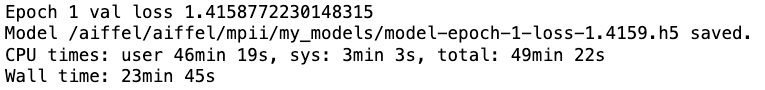

- 모델의 성능을 평가하기 위해 5epoch를 돌리고, loss값을 반환하게 만들기 위해 코드 수정
- 추가적인 학습이 될 수 있게, train 함수 내에 model 인스턴스 정의 후 save파일을 불러오게 하는 것도 좋을 것 같은데, 학습의 경향면에서는 이미 학습된 것을 관찰할 수 없음
- trainer.run에서 loss value를 반환하도록 수정


In [17]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches
        
        # ------loss를 반환하기 위해 딕셔너리를 정의------
        history = {
            "train_loss": [],
            "val_loss": [],
        }
        
        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)

            # train_loss for each epoch
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)

            # val_loss for each epoch
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss
            
            # ------해당 에폭의 loss를 저장합니다.------
            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)
            
        return self.best_model, history

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


### 5 epochs에 대한 StackedHourglassNetwork 학습을 진행

In [18]:
%%time
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')

# Constants for hyperparameters
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file, history_stackedhourglass = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 2.8637 epoch total loss 2.8637
Trained batch 2 batch loss 2.62081814 epoch total loss 2.74225903
Trained batch 3 batch loss 2.3153069 epoch total loss 2.59994149
Trained batch 4 batch loss 2.02650952 epoch total loss 2.4565835
Trained batch 5 batch loss 1.97615397 epoch total loss 2.36049771
Trained batch 6 batch loss 2.19824 epoch total loss 2.33345485
Trained batch 7 batch loss 2.08896494 epoch total loss 2.29852748
Trained batch 8 batch loss 2.12769938 epoch total loss 2.277174
Trained batch 9 batch loss 2.24816322 epoch total loss 2.27395058
Trained batch 10 batch loss 2.15701962 epoch total loss 2.26225734
Trained batch 11 batch loss 2.19788647 epoch total loss 2.25640559
Trained batch 12 batch loss 2.14647198 epoch total loss 2.2472446
Trained batch 13 batch loss 2.1257937 epoch total loss 2.23790216
Trained batch 14 batch loss 2.0283978 epoch total loss 2.22293758
Trained batch 15 batch loss 1.99396026 epoch total loss 2.

Trained batch 124 batch loss 1.63199115 epoch total loss 1.81326938
Trained batch 125 batch loss 1.58168507 epoch total loss 1.81141663
Trained batch 126 batch loss 1.70366669 epoch total loss 1.81056142
Trained batch 127 batch loss 1.6645962 epoch total loss 1.80941212
Trained batch 128 batch loss 1.61252618 epoch total loss 1.80787396
Trained batch 129 batch loss 1.55816185 epoch total loss 1.80593824
Trained batch 130 batch loss 1.69082344 epoch total loss 1.80505276
Trained batch 131 batch loss 1.65673923 epoch total loss 1.80392063
Trained batch 132 batch loss 1.68839049 epoch total loss 1.80304527
Trained batch 133 batch loss 1.53594923 epoch total loss 1.80103707
Trained batch 134 batch loss 1.39621234 epoch total loss 1.79801595
Trained batch 135 batch loss 1.51359272 epoch total loss 1.79590917
Trained batch 136 batch loss 1.6088351 epoch total loss 1.79453373
Trained batch 137 batch loss 1.53972912 epoch total loss 1.79267383
Trained batch 138 batch loss 1.58820367 epoch tota

Trained batch 245 batch loss 1.62197161 epoch total loss 1.71363962
Trained batch 246 batch loss 1.58003902 epoch total loss 1.7130965
Trained batch 247 batch loss 1.64091992 epoch total loss 1.71280444
Trained batch 248 batch loss 1.65000129 epoch total loss 1.71255112
Trained batch 249 batch loss 1.62320185 epoch total loss 1.7121923
Trained batch 250 batch loss 1.65586388 epoch total loss 1.71196687
Trained batch 251 batch loss 1.60869 epoch total loss 1.71155548
Trained batch 252 batch loss 1.47458136 epoch total loss 1.71061516
Trained batch 253 batch loss 1.46930981 epoch total loss 1.70966136
Trained batch 254 batch loss 1.5050962 epoch total loss 1.70885599
Trained batch 255 batch loss 1.42730081 epoch total loss 1.70775187
Trained batch 256 batch loss 1.55040324 epoch total loss 1.70713723
Trained batch 257 batch loss 1.56696033 epoch total loss 1.70659173
Trained batch 258 batch loss 1.63713336 epoch total loss 1.70632255
Trained batch 259 batch loss 1.79097497 epoch total lo

Trained batch 366 batch loss 1.65024483 epoch total loss 1.67351675
Trained batch 367 batch loss 1.70932317 epoch total loss 1.67361438
Trained batch 368 batch loss 1.62840104 epoch total loss 1.6734916
Trained batch 369 batch loss 1.58833075 epoch total loss 1.67326081
Trained batch 370 batch loss 1.63806307 epoch total loss 1.67316568
Trained batch 371 batch loss 1.62438941 epoch total loss 1.67303419
Trained batch 372 batch loss 1.68424022 epoch total loss 1.67306435
Trained batch 373 batch loss 1.80807269 epoch total loss 1.67342627
Trained batch 374 batch loss 1.73593163 epoch total loss 1.6735934
Trained batch 375 batch loss 1.65063953 epoch total loss 1.67353225
Trained batch 376 batch loss 1.68275356 epoch total loss 1.67355669
Trained batch 377 batch loss 1.60613811 epoch total loss 1.67337787
Trained batch 378 batch loss 1.46784139 epoch total loss 1.67283416
Trained batch 379 batch loss 1.53901887 epoch total loss 1.67248106
Trained batch 380 batch loss 1.59128308 epoch tota

Trained batch 487 batch loss 1.76579785 epoch total loss 1.65039992
Trained batch 488 batch loss 1.68005049 epoch total loss 1.65046072
Trained batch 489 batch loss 1.65330958 epoch total loss 1.65046656
Trained batch 490 batch loss 1.64086103 epoch total loss 1.65044689
Trained batch 491 batch loss 1.52137768 epoch total loss 1.65018404
Trained batch 492 batch loss 1.57951641 epoch total loss 1.65004039
Trained batch 493 batch loss 1.49133754 epoch total loss 1.64971852
Trained batch 494 batch loss 1.65155017 epoch total loss 1.64972222
Trained batch 495 batch loss 1.62914407 epoch total loss 1.64968061
Trained batch 496 batch loss 1.60263383 epoch total loss 1.64958584
Trained batch 497 batch loss 1.55843401 epoch total loss 1.64940238
Trained batch 498 batch loss 1.54836035 epoch total loss 1.64919949
Trained batch 499 batch loss 1.58096886 epoch total loss 1.64906275
Trained batch 500 batch loss 1.59458566 epoch total loss 1.64895391
Trained batch 501 batch loss 1.58055031 epoch to

Trained batch 609 batch loss 1.54333055 epoch total loss 1.6295526
Trained batch 610 batch loss 1.4874332 epoch total loss 1.62931955
Trained batch 611 batch loss 1.55679512 epoch total loss 1.62920094
Trained batch 612 batch loss 1.55425525 epoch total loss 1.62907851
Trained batch 613 batch loss 1.60105038 epoch total loss 1.62903285
Trained batch 614 batch loss 1.62697816 epoch total loss 1.62902939
Trained batch 615 batch loss 1.51191115 epoch total loss 1.62883902
Trained batch 616 batch loss 1.52676713 epoch total loss 1.62867332
Trained batch 617 batch loss 1.64782059 epoch total loss 1.62870431
Trained batch 618 batch loss 1.61234677 epoch total loss 1.62867796
Trained batch 619 batch loss 1.5690887 epoch total loss 1.62858164
Trained batch 620 batch loss 1.54098225 epoch total loss 1.62844026
Trained batch 621 batch loss 1.51529384 epoch total loss 1.62825811
Trained batch 622 batch loss 1.44258904 epoch total loss 1.62795961
Trained batch 623 batch loss 1.3927331 epoch total 

Trained batch 731 batch loss 1.49515128 epoch total loss 1.61027944
Trained batch 732 batch loss 1.52764702 epoch total loss 1.61016643
Trained batch 733 batch loss 1.59824944 epoch total loss 1.61015022
Trained batch 734 batch loss 1.5293293 epoch total loss 1.61004007
Trained batch 735 batch loss 1.46535754 epoch total loss 1.60984313
Trained batch 736 batch loss 1.38691783 epoch total loss 1.60954034
Trained batch 737 batch loss 1.55132961 epoch total loss 1.60946131
Trained batch 738 batch loss 1.44401813 epoch total loss 1.60923707
Trained batch 739 batch loss 1.51810896 epoch total loss 1.60911369
Trained batch 740 batch loss 1.51195836 epoch total loss 1.60898244
Trained batch 741 batch loss 1.3487246 epoch total loss 1.60863125
Trained batch 742 batch loss 1.50375712 epoch total loss 1.60848987
Trained batch 743 batch loss 1.51700532 epoch total loss 1.60836673
Trained batch 744 batch loss 1.4982698 epoch total loss 1.60821879
Trained batch 745 batch loss 1.58744717 epoch total

Trained batch 852 batch loss 1.49650705 epoch total loss 1.59658456
Trained batch 853 batch loss 1.52078247 epoch total loss 1.59649563
Trained batch 854 batch loss 1.57377553 epoch total loss 1.59646904
Trained batch 855 batch loss 1.42552114 epoch total loss 1.59626913
Trained batch 856 batch loss 1.52807009 epoch total loss 1.59618938
Trained batch 857 batch loss 1.42125535 epoch total loss 1.59598529
Trained batch 858 batch loss 1.50002503 epoch total loss 1.59587348
Trained batch 859 batch loss 1.37971199 epoch total loss 1.59562182
Trained batch 860 batch loss 1.44981074 epoch total loss 1.59545231
Trained batch 861 batch loss 1.49966049 epoch total loss 1.59534097
Trained batch 862 batch loss 1.4592793 epoch total loss 1.59518313
Trained batch 863 batch loss 1.68706131 epoch total loss 1.59528959
Trained batch 864 batch loss 1.62865567 epoch total loss 1.59532821
Trained batch 865 batch loss 1.6787281 epoch total loss 1.59542453
Trained batch 866 batch loss 1.54062843 epoch tota

Trained batch 973 batch loss 1.4618777 epoch total loss 1.58557689
Trained batch 974 batch loss 1.39169097 epoch total loss 1.58537793
Trained batch 975 batch loss 1.41883242 epoch total loss 1.5852071
Trained batch 976 batch loss 1.43786335 epoch total loss 1.58505607
Trained batch 977 batch loss 1.45533085 epoch total loss 1.58492339
Trained batch 978 batch loss 1.46964645 epoch total loss 1.58480537
Trained batch 979 batch loss 1.4791069 epoch total loss 1.58469748
Trained batch 980 batch loss 1.40848696 epoch total loss 1.5845176
Trained batch 981 batch loss 1.43883371 epoch total loss 1.58436918
Trained batch 982 batch loss 1.44052804 epoch total loss 1.58422267
Trained batch 983 batch loss 1.52157497 epoch total loss 1.58415902
Trained batch 984 batch loss 1.48408031 epoch total loss 1.58405733
Trained batch 985 batch loss 1.45688248 epoch total loss 1.58392823
Trained batch 986 batch loss 1.54045892 epoch total loss 1.58388412
Trained batch 987 batch loss 1.58048654 epoch total 

Trained batch 1093 batch loss 1.63154089 epoch total loss 1.57227743
Trained batch 1094 batch loss 1.56109655 epoch total loss 1.57226729
Trained batch 1095 batch loss 1.51123309 epoch total loss 1.5722115
Trained batch 1096 batch loss 1.63141894 epoch total loss 1.57226562
Trained batch 1097 batch loss 1.52340448 epoch total loss 1.57222116
Trained batch 1098 batch loss 1.54057777 epoch total loss 1.57219219
Trained batch 1099 batch loss 1.5125643 epoch total loss 1.57213795
Trained batch 1100 batch loss 1.530532 epoch total loss 1.57210016
Trained batch 1101 batch loss 1.46864653 epoch total loss 1.57200623
Trained batch 1102 batch loss 1.46807063 epoch total loss 1.57191181
Trained batch 1103 batch loss 1.59680605 epoch total loss 1.57193434
Trained batch 1104 batch loss 1.47451711 epoch total loss 1.57184613
Trained batch 1105 batch loss 1.51520491 epoch total loss 1.57179487
Trained batch 1106 batch loss 1.49922955 epoch total loss 1.5717293
Trained batch 1107 batch loss 1.4304044

Trained batch 1213 batch loss 1.54022 epoch total loss 1.56152129
Trained batch 1214 batch loss 1.41014743 epoch total loss 1.5613966
Trained batch 1215 batch loss 1.39706302 epoch total loss 1.56126142
Trained batch 1216 batch loss 1.42280984 epoch total loss 1.56114757
Trained batch 1217 batch loss 1.44679642 epoch total loss 1.56105363
Trained batch 1218 batch loss 1.42525959 epoch total loss 1.56094217
Trained batch 1219 batch loss 1.51687014 epoch total loss 1.56090593
Trained batch 1220 batch loss 1.51100051 epoch total loss 1.56086504
Trained batch 1221 batch loss 1.49377203 epoch total loss 1.56081009
Trained batch 1222 batch loss 1.52463388 epoch total loss 1.56078053
Trained batch 1223 batch loss 1.29125583 epoch total loss 1.56056011
Trained batch 1224 batch loss 1.32970035 epoch total loss 1.56037152
Trained batch 1225 batch loss 1.37595046 epoch total loss 1.56022108
Trained batch 1226 batch loss 1.47233689 epoch total loss 1.56014931
Trained batch 1227 batch loss 1.537088

Trained batch 1333 batch loss 1.19829774 epoch total loss 1.55016875
Trained batch 1334 batch loss 1.24574089 epoch total loss 1.54994071
Trained batch 1335 batch loss 1.50212932 epoch total loss 1.54990494
Trained batch 1336 batch loss 1.46616125 epoch total loss 1.54984212
Trained batch 1337 batch loss 1.5703336 epoch total loss 1.5498575
Trained batch 1338 batch loss 1.46542859 epoch total loss 1.54979432
Trained batch 1339 batch loss 1.36934924 epoch total loss 1.54965961
Trained batch 1340 batch loss 1.37241459 epoch total loss 1.54952717
Trained batch 1341 batch loss 1.28541672 epoch total loss 1.54933023
Trained batch 1342 batch loss 1.40227032 epoch total loss 1.54922068
Trained batch 1343 batch loss 1.43301165 epoch total loss 1.54913425
Trained batch 1344 batch loss 1.43668473 epoch total loss 1.54905069
Trained batch 1345 batch loss 1.47857833 epoch total loss 1.54899824
Trained batch 1346 batch loss 1.50254107 epoch total loss 1.54896367
Trained batch 1347 batch loss 1.3109

Validated batch 107 batch loss 1.48882687
Validated batch 108 batch loss 1.41404879
Validated batch 109 batch loss 1.55159593
Validated batch 110 batch loss 1.43352056
Validated batch 111 batch loss 1.40903473
Validated batch 112 batch loss 1.47871447
Validated batch 113 batch loss 1.40655518
Validated batch 114 batch loss 1.41591477
Validated batch 115 batch loss 1.43151045
Validated batch 116 batch loss 1.50597477
Validated batch 117 batch loss 1.41893613
Validated batch 118 batch loss 1.40431786
Validated batch 119 batch loss 1.38142359
Validated batch 120 batch loss 1.40707183
Validated batch 121 batch loss 1.5115118
Validated batch 122 batch loss 1.35784268
Validated batch 123 batch loss 1.44652724
Validated batch 124 batch loss 1.44791794
Validated batch 125 batch loss 1.46848202
Validated batch 126 batch loss 1.44091189
Validated batch 127 batch loss 1.37951958
Validated batch 128 batch loss 1.47991729
Validated batch 129 batch loss 1.49086
Validated batch 130 batch loss 1.44383

Trained batch 72 batch loss 1.42752218 epoch total loss 1.42661762
Trained batch 73 batch loss 1.40846515 epoch total loss 1.42636895
Trained batch 74 batch loss 1.38453639 epoch total loss 1.42580366
Trained batch 75 batch loss 1.51378536 epoch total loss 1.42697668
Trained batch 76 batch loss 1.35602617 epoch total loss 1.42604315
Trained batch 77 batch loss 1.35546434 epoch total loss 1.42512655
Trained batch 78 batch loss 1.34652007 epoch total loss 1.42411876
Trained batch 79 batch loss 1.36769557 epoch total loss 1.42340457
Trained batch 80 batch loss 1.49985075 epoch total loss 1.42436
Trained batch 81 batch loss 1.44560397 epoch total loss 1.4246223
Trained batch 82 batch loss 1.62052274 epoch total loss 1.42701137
Trained batch 83 batch loss 1.50995851 epoch total loss 1.4280107
Trained batch 84 batch loss 1.46667147 epoch total loss 1.42847097
Trained batch 85 batch loss 1.27135038 epoch total loss 1.42662251
Trained batch 86 batch loss 1.39994025 epoch total loss 1.42631221


Trained batch 194 batch loss 1.3376677 epoch total loss 1.42923176
Trained batch 195 batch loss 1.45543861 epoch total loss 1.42936623
Trained batch 196 batch loss 1.41492212 epoch total loss 1.42929244
Trained batch 197 batch loss 1.42241168 epoch total loss 1.42925763
Trained batch 198 batch loss 1.50005662 epoch total loss 1.42961526
Trained batch 199 batch loss 1.39188552 epoch total loss 1.4294256
Trained batch 200 batch loss 1.50823438 epoch total loss 1.42981958
Trained batch 201 batch loss 1.43400192 epoch total loss 1.42984045
Trained batch 202 batch loss 1.2718904 epoch total loss 1.42905843
Trained batch 203 batch loss 1.42508948 epoch total loss 1.42903876
Trained batch 204 batch loss 1.31435895 epoch total loss 1.42847669
Trained batch 205 batch loss 1.31169736 epoch total loss 1.42790711
Trained batch 206 batch loss 1.31638241 epoch total loss 1.42736566
Trained batch 207 batch loss 1.3503406 epoch total loss 1.42699361
Trained batch 208 batch loss 1.35766125 epoch total 

Trained batch 316 batch loss 1.4046371 epoch total loss 1.42642438
Trained batch 317 batch loss 1.26951671 epoch total loss 1.42592943
Trained batch 318 batch loss 1.34064162 epoch total loss 1.42566121
Trained batch 319 batch loss 1.30654013 epoch total loss 1.42528784
Trained batch 320 batch loss 1.22624516 epoch total loss 1.42466581
Trained batch 321 batch loss 1.23743725 epoch total loss 1.42408252
Trained batch 322 batch loss 1.48267841 epoch total loss 1.42426443
Trained batch 323 batch loss 1.48594368 epoch total loss 1.4244554
Trained batch 324 batch loss 1.58397198 epoch total loss 1.42494774
Trained batch 325 batch loss 1.45237982 epoch total loss 1.42503226
Trained batch 326 batch loss 1.48628235 epoch total loss 1.42522013
Trained batch 327 batch loss 1.34887052 epoch total loss 1.42498672
Trained batch 328 batch loss 1.31771803 epoch total loss 1.42465961
Trained batch 329 batch loss 1.45319152 epoch total loss 1.42474639
Trained batch 330 batch loss 1.45265365 epoch tota

Trained batch 437 batch loss 1.35913801 epoch total loss 1.41587424
Trained batch 438 batch loss 1.38824582 epoch total loss 1.41581118
Trained batch 439 batch loss 1.3818922 epoch total loss 1.41573393
Trained batch 440 batch loss 1.39835405 epoch total loss 1.41569448
Trained batch 441 batch loss 1.35727024 epoch total loss 1.41556203
Trained batch 442 batch loss 1.40630829 epoch total loss 1.41554117
Trained batch 443 batch loss 1.50209296 epoch total loss 1.41573644
Trained batch 444 batch loss 1.36138964 epoch total loss 1.41561413
Trained batch 445 batch loss 1.37268353 epoch total loss 1.41551757
Trained batch 446 batch loss 1.27483463 epoch total loss 1.41520214
Trained batch 447 batch loss 1.35809565 epoch total loss 1.41507447
Trained batch 448 batch loss 1.32976711 epoch total loss 1.41488397
Trained batch 449 batch loss 1.47195601 epoch total loss 1.41501117
Trained batch 450 batch loss 1.32774484 epoch total loss 1.41481733
Trained batch 451 batch loss 1.33046913 epoch tot

Trained batch 558 batch loss 1.26467586 epoch total loss 1.40613902
Trained batch 559 batch loss 1.35080349 epoch total loss 1.40604007
Trained batch 560 batch loss 1.32188869 epoch total loss 1.40588975
Trained batch 561 batch loss 1.41092515 epoch total loss 1.40589881
Trained batch 562 batch loss 1.35179138 epoch total loss 1.40580261
Trained batch 563 batch loss 1.44349277 epoch total loss 1.40586948
Trained batch 564 batch loss 1.39506936 epoch total loss 1.40585029
Trained batch 565 batch loss 1.55239272 epoch total loss 1.40610969
Trained batch 566 batch loss 1.35084128 epoch total loss 1.40601206
Trained batch 567 batch loss 1.41854811 epoch total loss 1.40603411
Trained batch 568 batch loss 1.25298548 epoch total loss 1.40576458
Trained batch 569 batch loss 1.36433196 epoch total loss 1.40569174
Trained batch 570 batch loss 1.40061963 epoch total loss 1.40568292
Trained batch 571 batch loss 1.26800489 epoch total loss 1.40544176
Trained batch 572 batch loss 1.16326988 epoch to

Trained batch 679 batch loss 1.37107038 epoch total loss 1.40023494
Trained batch 680 batch loss 1.43895793 epoch total loss 1.40029192
Trained batch 681 batch loss 1.43806076 epoch total loss 1.40034735
Trained batch 682 batch loss 1.39331663 epoch total loss 1.40033698
Trained batch 683 batch loss 1.31437027 epoch total loss 1.40021122
Trained batch 684 batch loss 1.42986703 epoch total loss 1.40025449
Trained batch 685 batch loss 1.41249251 epoch total loss 1.40027237
Trained batch 686 batch loss 1.36532235 epoch total loss 1.40022135
Trained batch 687 batch loss 1.32122827 epoch total loss 1.40010643
Trained batch 688 batch loss 1.22816527 epoch total loss 1.39985645
Trained batch 689 batch loss 1.26539385 epoch total loss 1.3996613
Trained batch 690 batch loss 1.30067635 epoch total loss 1.39951777
Trained batch 691 batch loss 1.33832252 epoch total loss 1.3994292
Trained batch 692 batch loss 1.30384934 epoch total loss 1.39929116
Trained batch 693 batch loss 1.19636607 epoch tota

Trained batch 800 batch loss 1.367028 epoch total loss 1.39486325
Trained batch 801 batch loss 1.37508726 epoch total loss 1.39483869
Trained batch 802 batch loss 1.26493 epoch total loss 1.39467657
Trained batch 803 batch loss 1.31230795 epoch total loss 1.39457393
Trained batch 804 batch loss 1.33175027 epoch total loss 1.39449584
Trained batch 805 batch loss 1.43101 epoch total loss 1.39454126
Trained batch 806 batch loss 1.44610703 epoch total loss 1.39460528
Trained batch 807 batch loss 1.31116199 epoch total loss 1.39450192
Trained batch 808 batch loss 1.3915391 epoch total loss 1.39449811
Trained batch 809 batch loss 1.35815525 epoch total loss 1.39445329
Trained batch 810 batch loss 1.2598846 epoch total loss 1.39428711
Trained batch 811 batch loss 1.39437222 epoch total loss 1.39428723
Trained batch 812 batch loss 1.35430098 epoch total loss 1.394238
Trained batch 813 batch loss 1.31958675 epoch total loss 1.39414608
Trained batch 814 batch loss 1.41029942 epoch total loss 1.3

Trained batch 922 batch loss 1.23969233 epoch total loss 1.38779545
Trained batch 923 batch loss 1.14768362 epoch total loss 1.38753533
Trained batch 924 batch loss 1.23496389 epoch total loss 1.38737023
Trained batch 925 batch loss 1.270998 epoch total loss 1.38724434
Trained batch 926 batch loss 1.38860011 epoch total loss 1.38724577
Trained batch 927 batch loss 1.2343353 epoch total loss 1.38708091
Trained batch 928 batch loss 1.3634274 epoch total loss 1.3870554
Trained batch 929 batch loss 1.38749111 epoch total loss 1.38705575
Trained batch 930 batch loss 1.44558966 epoch total loss 1.3871187
Trained batch 931 batch loss 1.39766836 epoch total loss 1.38713
Trained batch 932 batch loss 1.38641131 epoch total loss 1.38712919
Trained batch 933 batch loss 1.65450931 epoch total loss 1.38741589
Trained batch 934 batch loss 1.5744096 epoch total loss 1.38761616
Trained batch 935 batch loss 1.33276439 epoch total loss 1.38755739
Trained batch 936 batch loss 1.33801889 epoch total loss 1

Trained batch 1043 batch loss 1.39920139 epoch total loss 1.38535392
Trained batch 1044 batch loss 1.33573365 epoch total loss 1.38530636
Trained batch 1045 batch loss 1.30793524 epoch total loss 1.38523245
Trained batch 1046 batch loss 1.52741683 epoch total loss 1.38536835
Trained batch 1047 batch loss 1.40953612 epoch total loss 1.38539147
Trained batch 1048 batch loss 1.28131187 epoch total loss 1.38529217
Trained batch 1049 batch loss 1.39651287 epoch total loss 1.3853029
Trained batch 1050 batch loss 1.48762488 epoch total loss 1.38540041
Trained batch 1051 batch loss 1.46041846 epoch total loss 1.38547182
Trained batch 1052 batch loss 1.33566058 epoch total loss 1.38542449
Trained batch 1053 batch loss 1.36274588 epoch total loss 1.38540304
Trained batch 1054 batch loss 1.25003421 epoch total loss 1.38527453
Trained batch 1055 batch loss 1.34621465 epoch total loss 1.38523746
Trained batch 1056 batch loss 1.35180879 epoch total loss 1.38520586
Trained batch 1057 batch loss 1.340

Trained batch 1163 batch loss 1.34637344 epoch total loss 1.38151228
Trained batch 1164 batch loss 1.40472317 epoch total loss 1.38153219
Trained batch 1165 batch loss 1.27916873 epoch total loss 1.38144433
Trained batch 1166 batch loss 1.24412692 epoch total loss 1.38132656
Trained batch 1167 batch loss 1.23829567 epoch total loss 1.38120401
Trained batch 1168 batch loss 1.2382865 epoch total loss 1.3810817
Trained batch 1169 batch loss 1.22688317 epoch total loss 1.38094985
Trained batch 1170 batch loss 1.37272251 epoch total loss 1.3809427
Trained batch 1171 batch loss 1.32824194 epoch total loss 1.38089776
Trained batch 1172 batch loss 1.41850615 epoch total loss 1.38092983
Trained batch 1173 batch loss 1.27534926 epoch total loss 1.38083982
Trained batch 1174 batch loss 1.43676138 epoch total loss 1.38088751
Trained batch 1175 batch loss 1.4398762 epoch total loss 1.38093758
Trained batch 1176 batch loss 1.25165617 epoch total loss 1.38082767
Trained batch 1177 batch loss 1.346795

Trained batch 1283 batch loss 1.34686089 epoch total loss 1.37570906
Trained batch 1284 batch loss 1.20646131 epoch total loss 1.37557721
Trained batch 1285 batch loss 1.32078373 epoch total loss 1.37553465
Trained batch 1286 batch loss 1.25146842 epoch total loss 1.37543821
Trained batch 1287 batch loss 1.38460243 epoch total loss 1.37544537
Trained batch 1288 batch loss 1.27955627 epoch total loss 1.37537086
Trained batch 1289 batch loss 1.35301721 epoch total loss 1.37535357
Trained batch 1290 batch loss 1.39898658 epoch total loss 1.37537181
Trained batch 1291 batch loss 1.26236737 epoch total loss 1.37528419
Trained batch 1292 batch loss 1.29169393 epoch total loss 1.37521958
Trained batch 1293 batch loss 1.41606462 epoch total loss 1.37525117
Trained batch 1294 batch loss 1.30233145 epoch total loss 1.37519479
Trained batch 1295 batch loss 1.42774916 epoch total loss 1.37523532
Trained batch 1296 batch loss 1.38234639 epoch total loss 1.3752408
Trained batch 1297 batch loss 1.271

Validated batch 23 batch loss 1.43924332
Validated batch 24 batch loss 1.42847204
Validated batch 25 batch loss 1.37958169
Validated batch 26 batch loss 1.28120685
Validated batch 27 batch loss 1.23095834
Validated batch 28 batch loss 1.29823172
Validated batch 29 batch loss 1.37030101
Validated batch 30 batch loss 1.25946963
Validated batch 31 batch loss 1.28303218
Validated batch 32 batch loss 1.34681034
Validated batch 33 batch loss 1.35061729
Validated batch 34 batch loss 1.24813759
Validated batch 35 batch loss 1.21980441
Validated batch 36 batch loss 1.35737658
Validated batch 37 batch loss 1.35892725
Validated batch 38 batch loss 1.42393351
Validated batch 39 batch loss 1.4165827
Validated batch 40 batch loss 1.29417193
Validated batch 41 batch loss 1.47379827
Validated batch 42 batch loss 1.34653378
Validated batch 43 batch loss 1.3569845
Validated batch 44 batch loss 1.3923595
Validated batch 45 batch loss 1.09167397
Validated batch 46 batch loss 1.3747611
Validated batch 47 b

Trained batch 21 batch loss 1.28121305 epoch total loss 1.27426696
Trained batch 22 batch loss 1.37622464 epoch total loss 1.27890134
Trained batch 23 batch loss 1.29314399 epoch total loss 1.27952063
Trained batch 24 batch loss 1.23592842 epoch total loss 1.27770424
Trained batch 25 batch loss 1.12185907 epoch total loss 1.27147043
Trained batch 26 batch loss 1.09127355 epoch total loss 1.26453972
Trained batch 27 batch loss 1.18015218 epoch total loss 1.26141429
Trained batch 28 batch loss 1.46811545 epoch total loss 1.26879656
Trained batch 29 batch loss 1.33513451 epoch total loss 1.27108395
Trained batch 30 batch loss 1.3839978 epoch total loss 1.27484775
Trained batch 31 batch loss 1.28635144 epoch total loss 1.27521884
Trained batch 32 batch loss 1.35806406 epoch total loss 1.27780771
Trained batch 33 batch loss 1.27246022 epoch total loss 1.27764571
Trained batch 34 batch loss 1.18903279 epoch total loss 1.27503943
Trained batch 35 batch loss 1.24408174 epoch total loss 1.27415

Trained batch 144 batch loss 1.34005547 epoch total loss 1.29372585
Trained batch 145 batch loss 1.35593152 epoch total loss 1.29415488
Trained batch 146 batch loss 1.49394631 epoch total loss 1.29552329
Trained batch 147 batch loss 1.48933554 epoch total loss 1.29684162
Trained batch 148 batch loss 1.44080353 epoch total loss 1.29781449
Trained batch 149 batch loss 1.31252563 epoch total loss 1.29791319
Trained batch 150 batch loss 1.25379658 epoch total loss 1.2976191
Trained batch 151 batch loss 1.30826473 epoch total loss 1.29768956
Trained batch 152 batch loss 1.20060027 epoch total loss 1.29705083
Trained batch 153 batch loss 1.2902683 epoch total loss 1.29700649
Trained batch 154 batch loss 1.27582288 epoch total loss 1.29686892
Trained batch 155 batch loss 1.22162127 epoch total loss 1.2963835
Trained batch 156 batch loss 1.22637546 epoch total loss 1.29593468
Trained batch 157 batch loss 1.15096843 epoch total loss 1.2950114
Trained batch 158 batch loss 1.3418045 epoch total l

Trained batch 266 batch loss 1.29169583 epoch total loss 1.29589915
Trained batch 267 batch loss 1.35793936 epoch total loss 1.29613149
Trained batch 268 batch loss 1.35239577 epoch total loss 1.29634142
Trained batch 269 batch loss 1.31934428 epoch total loss 1.29642689
Trained batch 270 batch loss 1.2694155 epoch total loss 1.29632676
Trained batch 271 batch loss 1.26307702 epoch total loss 1.29620421
Trained batch 272 batch loss 1.29931498 epoch total loss 1.29621565
Trained batch 273 batch loss 1.31166148 epoch total loss 1.29627228
Trained batch 274 batch loss 1.20980036 epoch total loss 1.29595673
Trained batch 275 batch loss 1.25420666 epoch total loss 1.29580486
Trained batch 276 batch loss 1.14403605 epoch total loss 1.29525506
Trained batch 277 batch loss 1.24180055 epoch total loss 1.29506207
Trained batch 278 batch loss 1.23972571 epoch total loss 1.29486287
Trained batch 279 batch loss 1.32860041 epoch total loss 1.29498386
Trained batch 280 batch loss 1.31192863 epoch tot

Trained batch 387 batch loss 1.21699381 epoch total loss 1.29533911
Trained batch 388 batch loss 1.24147367 epoch total loss 1.29520035
Trained batch 389 batch loss 1.30951965 epoch total loss 1.29523706
Trained batch 390 batch loss 1.24225438 epoch total loss 1.29510117
Trained batch 391 batch loss 1.28558409 epoch total loss 1.29507685
Trained batch 392 batch loss 1.44896793 epoch total loss 1.29546952
Trained batch 393 batch loss 1.32933581 epoch total loss 1.29555571
Trained batch 394 batch loss 1.34109974 epoch total loss 1.29567122
Trained batch 395 batch loss 1.32762694 epoch total loss 1.29575217
Trained batch 396 batch loss 1.14236546 epoch total loss 1.29536486
Trained batch 397 batch loss 1.12564707 epoch total loss 1.29493737
Trained batch 398 batch loss 1.31409407 epoch total loss 1.29498553
Trained batch 399 batch loss 1.33710706 epoch total loss 1.29509103
Trained batch 400 batch loss 1.4204576 epoch total loss 1.29540455
Trained batch 401 batch loss 1.44540238 epoch tot

Trained batch 509 batch loss 1.36018729 epoch total loss 1.29430199
Trained batch 510 batch loss 1.39549518 epoch total loss 1.29450035
Trained batch 511 batch loss 1.31699812 epoch total loss 1.29454446
Trained batch 512 batch loss 1.42653906 epoch total loss 1.29480219
Trained batch 513 batch loss 1.31274271 epoch total loss 1.29483712
Trained batch 514 batch loss 1.4579258 epoch total loss 1.29515445
Trained batch 515 batch loss 1.30610108 epoch total loss 1.29517579
Trained batch 516 batch loss 1.41712236 epoch total loss 1.29541206
Trained batch 517 batch loss 1.21808755 epoch total loss 1.29526246
Trained batch 518 batch loss 1.2277776 epoch total loss 1.29513216
Trained batch 519 batch loss 1.16192186 epoch total loss 1.2948755
Trained batch 520 batch loss 1.24446392 epoch total loss 1.29477859
Trained batch 521 batch loss 1.22767985 epoch total loss 1.29464972
Trained batch 522 batch loss 1.21920824 epoch total loss 1.29450524
Trained batch 523 batch loss 1.38313913 epoch total

Trained batch 630 batch loss 1.34814286 epoch total loss 1.29678988
Trained batch 631 batch loss 1.32623863 epoch total loss 1.2968365
Trained batch 632 batch loss 1.28747404 epoch total loss 1.29682171
Trained batch 633 batch loss 1.14214349 epoch total loss 1.29657733
Trained batch 634 batch loss 1.09674668 epoch total loss 1.29626215
Trained batch 635 batch loss 1.1949594 epoch total loss 1.29610264
Trained batch 636 batch loss 1.32811248 epoch total loss 1.29615295
Trained batch 637 batch loss 1.3621701 epoch total loss 1.29625654
Trained batch 638 batch loss 1.5070982 epoch total loss 1.29658699
Trained batch 639 batch loss 1.57672334 epoch total loss 1.29702544
Trained batch 640 batch loss 1.38900757 epoch total loss 1.29716909
Trained batch 641 batch loss 1.29357469 epoch total loss 1.29716349
Trained batch 642 batch loss 1.28274369 epoch total loss 1.29714096
Trained batch 643 batch loss 1.14871287 epoch total loss 1.29691017
Trained batch 644 batch loss 1.26541972 epoch total 

Trained batch 752 batch loss 1.28487968 epoch total loss 1.29556739
Trained batch 753 batch loss 1.22685623 epoch total loss 1.29547608
Trained batch 754 batch loss 1.41110873 epoch total loss 1.2956295
Trained batch 755 batch loss 1.50520599 epoch total loss 1.29590714
Trained batch 756 batch loss 1.3128407 epoch total loss 1.29592955
Trained batch 757 batch loss 1.22101474 epoch total loss 1.29583061
Trained batch 758 batch loss 1.23751986 epoch total loss 1.29575372
Trained batch 759 batch loss 1.18156397 epoch total loss 1.29560328
Trained batch 760 batch loss 1.2212857 epoch total loss 1.29550552
Trained batch 761 batch loss 1.27236128 epoch total loss 1.29547501
Trained batch 762 batch loss 1.29505157 epoch total loss 1.29547453
Trained batch 763 batch loss 1.25900173 epoch total loss 1.29542661
Trained batch 764 batch loss 1.16401935 epoch total loss 1.29525459
Trained batch 765 batch loss 1.26411569 epoch total loss 1.29521394
Trained batch 766 batch loss 1.27602911 epoch total

Trained batch 874 batch loss 1.23507667 epoch total loss 1.29222238
Trained batch 875 batch loss 1.1211307 epoch total loss 1.29202676
Trained batch 876 batch loss 1.14875829 epoch total loss 1.29186332
Trained batch 877 batch loss 1.28816378 epoch total loss 1.29185915
Trained batch 878 batch loss 1.34123755 epoch total loss 1.2919153
Trained batch 879 batch loss 1.24664783 epoch total loss 1.29186392
Trained batch 880 batch loss 1.22921586 epoch total loss 1.29179275
Trained batch 881 batch loss 1.15790462 epoch total loss 1.29164076
Trained batch 882 batch loss 1.19371748 epoch total loss 1.29152977
Trained batch 883 batch loss 1.51414657 epoch total loss 1.2917819
Trained batch 884 batch loss 1.24342775 epoch total loss 1.29172719
Trained batch 885 batch loss 1.22865081 epoch total loss 1.2916559
Trained batch 886 batch loss 1.13537025 epoch total loss 1.29147947
Trained batch 887 batch loss 0.99266845 epoch total loss 1.2911427
Trained batch 888 batch loss 0.955696225 epoch total 

Trained batch 996 batch loss 1.23723066 epoch total loss 1.28847456
Trained batch 997 batch loss 1.24190867 epoch total loss 1.28842795
Trained batch 998 batch loss 1.28473842 epoch total loss 1.28842425
Trained batch 999 batch loss 1.25090885 epoch total loss 1.2883867
Trained batch 1000 batch loss 1.25245178 epoch total loss 1.2883507
Trained batch 1001 batch loss 1.25307083 epoch total loss 1.28831542
Trained batch 1002 batch loss 1.26786649 epoch total loss 1.28829503
Trained batch 1003 batch loss 1.20133579 epoch total loss 1.28820825
Trained batch 1004 batch loss 1.14744461 epoch total loss 1.28806806
Trained batch 1005 batch loss 1.14465964 epoch total loss 1.28792536
Trained batch 1006 batch loss 1.30041111 epoch total loss 1.28793776
Trained batch 1007 batch loss 1.28538656 epoch total loss 1.28793526
Trained batch 1008 batch loss 1.33082128 epoch total loss 1.28797781
Trained batch 1009 batch loss 1.15798843 epoch total loss 1.28784895
Trained batch 1010 batch loss 1.14751792

Trained batch 1116 batch loss 1.21065044 epoch total loss 1.28688896
Trained batch 1117 batch loss 1.25605917 epoch total loss 1.28686142
Trained batch 1118 batch loss 1.30064642 epoch total loss 1.2868737
Trained batch 1119 batch loss 1.1987431 epoch total loss 1.28679502
Trained batch 1120 batch loss 1.19321299 epoch total loss 1.28671145
Trained batch 1121 batch loss 1.32481611 epoch total loss 1.28674543
Trained batch 1122 batch loss 1.28834581 epoch total loss 1.28674686
Trained batch 1123 batch loss 1.32157302 epoch total loss 1.28677785
Trained batch 1124 batch loss 1.31695819 epoch total loss 1.2868048
Trained batch 1125 batch loss 1.28319216 epoch total loss 1.28680158
Trained batch 1126 batch loss 1.4422127 epoch total loss 1.28693962
Trained batch 1127 batch loss 1.2933054 epoch total loss 1.28694522
Trained batch 1128 batch loss 1.24015141 epoch total loss 1.28690374
Trained batch 1129 batch loss 1.27801728 epoch total loss 1.28689599
Trained batch 1130 batch loss 1.2239248

Trained batch 1236 batch loss 1.21839833 epoch total loss 1.28477252
Trained batch 1237 batch loss 1.28674316 epoch total loss 1.28477407
Trained batch 1238 batch loss 1.14329767 epoch total loss 1.28465974
Trained batch 1239 batch loss 1.15680146 epoch total loss 1.28455663
Trained batch 1240 batch loss 1.12749028 epoch total loss 1.28442991
Trained batch 1241 batch loss 1.16906857 epoch total loss 1.28433692
Trained batch 1242 batch loss 1.1217916 epoch total loss 1.28420615
Trained batch 1243 batch loss 1.18755567 epoch total loss 1.28412831
Trained batch 1244 batch loss 1.20645928 epoch total loss 1.28406584
Trained batch 1245 batch loss 1.18530774 epoch total loss 1.28398657
Trained batch 1246 batch loss 1.239568 epoch total loss 1.28395092
Trained batch 1247 batch loss 1.29414105 epoch total loss 1.28395915
Trained batch 1248 batch loss 1.28166699 epoch total loss 1.28395724
Trained batch 1249 batch loss 1.38156235 epoch total loss 1.28403544
Trained batch 1250 batch loss 1.16180

Trained batch 1356 batch loss 1.18701863 epoch total loss 1.28185213
Trained batch 1357 batch loss 1.25798428 epoch total loss 1.28183448
Trained batch 1358 batch loss 1.24714386 epoch total loss 1.28180897
Trained batch 1359 batch loss 1.27361286 epoch total loss 1.28180289
Trained batch 1360 batch loss 1.0258677 epoch total loss 1.28161466
Trained batch 1361 batch loss 0.895894289 epoch total loss 1.2813313
Trained batch 1362 batch loss 1.13324738 epoch total loss 1.28122258
Trained batch 1363 batch loss 1.32544422 epoch total loss 1.28125501
Trained batch 1364 batch loss 1.35376036 epoch total loss 1.28130817
Trained batch 1365 batch loss 1.42675567 epoch total loss 1.28141475
Trained batch 1366 batch loss 1.37374544 epoch total loss 1.28148234
Trained batch 1367 batch loss 1.45148587 epoch total loss 1.28160679
Trained batch 1368 batch loss 1.30883 epoch total loss 1.2816267
Trained batch 1369 batch loss 1.14999342 epoch total loss 1.2815305
Trained batch 1370 batch loss 1.08290029

Validated batch 145 batch loss 1.1571753
Validated batch 146 batch loss 1.14497709
Validated batch 147 batch loss 1.23419476
Validated batch 148 batch loss 1.27411675
Validated batch 149 batch loss 1.15048647
Validated batch 150 batch loss 1.28576398
Validated batch 151 batch loss 1.12385666
Validated batch 152 batch loss 1.23370576
Validated batch 153 batch loss 1.3354764
Validated batch 154 batch loss 1.39426041
Validated batch 155 batch loss 1.19267
Validated batch 156 batch loss 1.37295306
Validated batch 157 batch loss 1.0960511
Validated batch 158 batch loss 1.13506162
Validated batch 159 batch loss 1.23697186
Validated batch 160 batch loss 1.21310616
Validated batch 161 batch loss 1.36300993
Validated batch 162 batch loss 1.30693412
Validated batch 163 batch loss 1.15827096
Validated batch 164 batch loss 1.22346115
Validated batch 165 batch loss 1.17773271
Validated batch 166 batch loss 1.23351049
Validated batch 167 batch loss 1.28770816
Validated batch 168 batch loss 1.2527405

Trained batch 96 batch loss 1.20725894 epoch total loss 1.22313225
Trained batch 97 batch loss 1.18748713 epoch total loss 1.22276473
Trained batch 98 batch loss 1.15542412 epoch total loss 1.22207761
Trained batch 99 batch loss 1.12751937 epoch total loss 1.22112238
Trained batch 100 batch loss 1.10476136 epoch total loss 1.21995878
Trained batch 101 batch loss 1.17830312 epoch total loss 1.21954644
Trained batch 102 batch loss 1.10159183 epoch total loss 1.21839
Trained batch 103 batch loss 1.08580804 epoch total loss 1.21710277
Trained batch 104 batch loss 1.0804199 epoch total loss 1.2157886
Trained batch 105 batch loss 1.1654166 epoch total loss 1.21530879
Trained batch 106 batch loss 1.32027972 epoch total loss 1.21629906
Trained batch 107 batch loss 1.05267644 epoch total loss 1.21476984
Trained batch 108 batch loss 1.10031533 epoch total loss 1.21371007
Trained batch 109 batch loss 1.33260977 epoch total loss 1.21480095
Trained batch 110 batch loss 1.36394882 epoch total loss 1

Trained batch 218 batch loss 1.20532894 epoch total loss 1.22996545
Trained batch 219 batch loss 1.13625121 epoch total loss 1.22953761
Trained batch 220 batch loss 1.14758909 epoch total loss 1.22916508
Trained batch 221 batch loss 1.14496148 epoch total loss 1.22878408
Trained batch 222 batch loss 1.13765693 epoch total loss 1.22837365
Trained batch 223 batch loss 1.08474934 epoch total loss 1.22772956
Trained batch 224 batch loss 1.16547585 epoch total loss 1.22745156
Trained batch 225 batch loss 1.12038898 epoch total loss 1.2269758
Trained batch 226 batch loss 1.10628581 epoch total loss 1.22644174
Trained batch 227 batch loss 1.0718869 epoch total loss 1.22576094
Trained batch 228 batch loss 1.16750598 epoch total loss 1.22550547
Trained batch 229 batch loss 1.12628651 epoch total loss 1.22507215
Trained batch 230 batch loss 1.20106959 epoch total loss 1.22496784
Trained batch 231 batch loss 1.52001107 epoch total loss 1.22624516
Trained batch 232 batch loss 1.43138719 epoch tota

Trained batch 339 batch loss 1.23064506 epoch total loss 1.22678113
Trained batch 340 batch loss 1.17742896 epoch total loss 1.22663593
Trained batch 341 batch loss 1.07200754 epoch total loss 1.22618246
Trained batch 342 batch loss 1.30049264 epoch total loss 1.22639978
Trained batch 343 batch loss 1.172436 epoch total loss 1.22624242
Trained batch 344 batch loss 1.15561724 epoch total loss 1.22603714
Trained batch 345 batch loss 1.1633544 epoch total loss 1.22585547
Trained batch 346 batch loss 1.20227265 epoch total loss 1.22578728
Trained batch 347 batch loss 1.34851694 epoch total loss 1.22614098
Trained batch 348 batch loss 1.3624711 epoch total loss 1.2265327
Trained batch 349 batch loss 1.18884313 epoch total loss 1.22642469
Trained batch 350 batch loss 1.25467098 epoch total loss 1.2265054
Trained batch 351 batch loss 1.25247598 epoch total loss 1.22657931
Trained batch 352 batch loss 1.25056016 epoch total loss 1.2266475
Trained batch 353 batch loss 1.3815105 epoch total loss

Trained batch 461 batch loss 1.25731611 epoch total loss 1.22172189
Trained batch 462 batch loss 1.13676 epoch total loss 1.22153807
Trained batch 463 batch loss 1.27081943 epoch total loss 1.22164452
Trained batch 464 batch loss 1.33225131 epoch total loss 1.22188294
Trained batch 465 batch loss 1.15089154 epoch total loss 1.22173023
Trained batch 466 batch loss 1.10072231 epoch total loss 1.22147048
Trained batch 467 batch loss 1.1535058 epoch total loss 1.22132492
Trained batch 468 batch loss 1.1502167 epoch total loss 1.22117305
Trained batch 469 batch loss 1.12718415 epoch total loss 1.22097266
Trained batch 470 batch loss 1.13191187 epoch total loss 1.22078311
Trained batch 471 batch loss 1.24924719 epoch total loss 1.22084355
Trained batch 472 batch loss 1.29429257 epoch total loss 1.22099924
Trained batch 473 batch loss 1.35702336 epoch total loss 1.22128677
Trained batch 474 batch loss 1.2669524 epoch total loss 1.22138309
Trained batch 475 batch loss 1.25242591 epoch total lo

Trained batch 583 batch loss 1.26548457 epoch total loss 1.2231586
Trained batch 584 batch loss 1.4210937 epoch total loss 1.22349751
Trained batch 585 batch loss 1.39998746 epoch total loss 1.22379911
Trained batch 586 batch loss 1.21682394 epoch total loss 1.22378719
Trained batch 587 batch loss 1.37104046 epoch total loss 1.224038
Trained batch 588 batch loss 1.25914812 epoch total loss 1.22409773
Trained batch 589 batch loss 1.3760581 epoch total loss 1.2243557
Trained batch 590 batch loss 1.51398396 epoch total loss 1.2248466
Trained batch 591 batch loss 1.37543058 epoch total loss 1.22510135
Trained batch 592 batch loss 1.36250126 epoch total loss 1.22533345
Trained batch 593 batch loss 1.38919711 epoch total loss 1.22560978
Trained batch 594 batch loss 1.2335608 epoch total loss 1.22562325
Trained batch 595 batch loss 1.17844605 epoch total loss 1.22554398
Trained batch 596 batch loss 1.1686058 epoch total loss 1.22544837
Trained batch 597 batch loss 1.33398843 epoch total loss 

Trained batch 705 batch loss 1.16295397 epoch total loss 1.2249676
Trained batch 706 batch loss 1.23043478 epoch total loss 1.22497535
Trained batch 707 batch loss 1.27806783 epoch total loss 1.22505045
Trained batch 708 batch loss 1.19323277 epoch total loss 1.22500551
Trained batch 709 batch loss 1.346192 epoch total loss 1.22517645
Trained batch 710 batch loss 1.25592339 epoch total loss 1.22521973
Trained batch 711 batch loss 1.3119297 epoch total loss 1.22534168
Trained batch 712 batch loss 1.3010391 epoch total loss 1.22544801
Trained batch 713 batch loss 1.27708435 epoch total loss 1.22552049
Trained batch 714 batch loss 1.27736545 epoch total loss 1.22559309
Trained batch 715 batch loss 1.19029593 epoch total loss 1.22554374
Trained batch 716 batch loss 1.08904767 epoch total loss 1.225353
Trained batch 717 batch loss 1.11208773 epoch total loss 1.22519505
Trained batch 718 batch loss 1.28947258 epoch total loss 1.22528458
Trained batch 719 batch loss 1.25246096 epoch total los

Trained batch 827 batch loss 1.31698155 epoch total loss 1.22375357
Trained batch 828 batch loss 1.14685941 epoch total loss 1.22366071
Trained batch 829 batch loss 1.23975646 epoch total loss 1.22368014
Trained batch 830 batch loss 1.18951523 epoch total loss 1.22363901
Trained batch 831 batch loss 1.13175619 epoch total loss 1.22352839
Trained batch 832 batch loss 1.18892956 epoch total loss 1.22348678
Trained batch 833 batch loss 1.30527008 epoch total loss 1.22358501
Trained batch 834 batch loss 1.31677318 epoch total loss 1.22369683
Trained batch 835 batch loss 1.24813199 epoch total loss 1.22372603
Trained batch 836 batch loss 1.29463267 epoch total loss 1.22381079
Trained batch 837 batch loss 1.36626816 epoch total loss 1.2239809
Trained batch 838 batch loss 1.3448962 epoch total loss 1.22412515
Trained batch 839 batch loss 1.39108098 epoch total loss 1.22432423
Trained batch 840 batch loss 1.27797079 epoch total loss 1.224388
Trained batch 841 batch loss 1.23991573 epoch total 

Trained batch 948 batch loss 1.24825013 epoch total loss 1.22468829
Trained batch 949 batch loss 1.20835149 epoch total loss 1.22467113
Trained batch 950 batch loss 1.21334016 epoch total loss 1.2246592
Trained batch 951 batch loss 1.1142987 epoch total loss 1.22454309
Trained batch 952 batch loss 1.20965838 epoch total loss 1.2245276
Trained batch 953 batch loss 1.13522458 epoch total loss 1.2244339
Trained batch 954 batch loss 1.32434475 epoch total loss 1.22453856
Trained batch 955 batch loss 1.31846511 epoch total loss 1.22463703
Trained batch 956 batch loss 1.28254879 epoch total loss 1.22469759
Trained batch 957 batch loss 1.28027487 epoch total loss 1.22475564
Trained batch 958 batch loss 1.43457603 epoch total loss 1.22497475
Trained batch 959 batch loss 1.3840878 epoch total loss 1.22514057
Trained batch 960 batch loss 1.20081007 epoch total loss 1.22511518
Trained batch 961 batch loss 1.17484832 epoch total loss 1.22506285
Trained batch 962 batch loss 1.19730449 epoch total l

Trained batch 1069 batch loss 1.42111313 epoch total loss 1.22301531
Trained batch 1070 batch loss 1.38604343 epoch total loss 1.22316754
Trained batch 1071 batch loss 1.42933977 epoch total loss 1.22336006
Trained batch 1072 batch loss 1.27657974 epoch total loss 1.22340977
Trained batch 1073 batch loss 1.36562085 epoch total loss 1.22354221
Trained batch 1074 batch loss 1.28164697 epoch total loss 1.22359633
Trained batch 1075 batch loss 1.18345928 epoch total loss 1.22355902
Trained batch 1076 batch loss 1.22158074 epoch total loss 1.22355711
Trained batch 1077 batch loss 1.17897213 epoch total loss 1.22351575
Trained batch 1078 batch loss 1.2392658 epoch total loss 1.22353029
Trained batch 1079 batch loss 1.23245502 epoch total loss 1.22353852
Trained batch 1080 batch loss 1.23219156 epoch total loss 1.22354662
Trained batch 1081 batch loss 1.23926258 epoch total loss 1.22356105
Trained batch 1082 batch loss 1.12142706 epoch total loss 1.22346675
Trained batch 1083 batch loss 1.200

Trained batch 1189 batch loss 1.45711267 epoch total loss 1.2231791
Trained batch 1190 batch loss 1.19818068 epoch total loss 1.22315812
Trained batch 1191 batch loss 1.24511576 epoch total loss 1.22317648
Trained batch 1192 batch loss 1.15888119 epoch total loss 1.2231226
Trained batch 1193 batch loss 1.12404895 epoch total loss 1.22303951
Trained batch 1194 batch loss 1.4228555 epoch total loss 1.22320688
Trained batch 1195 batch loss 1.22307801 epoch total loss 1.22320676
Trained batch 1196 batch loss 1.29540634 epoch total loss 1.22326708
Trained batch 1197 batch loss 1.36791134 epoch total loss 1.22338796
Trained batch 1198 batch loss 1.21340227 epoch total loss 1.22337961
Trained batch 1199 batch loss 1.28913665 epoch total loss 1.22343445
Trained batch 1200 batch loss 1.29393339 epoch total loss 1.22349322
Trained batch 1201 batch loss 1.25973487 epoch total loss 1.2235235
Trained batch 1202 batch loss 1.22137094 epoch total loss 1.22352159
Trained batch 1203 batch loss 1.132009

Trained batch 1309 batch loss 1.19093585 epoch total loss 1.22377324
Trained batch 1310 batch loss 1.24097538 epoch total loss 1.22378635
Trained batch 1311 batch loss 1.2070365 epoch total loss 1.2237736
Trained batch 1312 batch loss 1.16147184 epoch total loss 1.22372615
Trained batch 1313 batch loss 1.27708268 epoch total loss 1.2237668
Trained batch 1314 batch loss 1.20176053 epoch total loss 1.22375
Trained batch 1315 batch loss 1.14935184 epoch total loss 1.22369337
Trained batch 1316 batch loss 1.24159694 epoch total loss 1.22370696
Trained batch 1317 batch loss 1.10502899 epoch total loss 1.22361684
Trained batch 1318 batch loss 1.01524436 epoch total loss 1.22345877
Trained batch 1319 batch loss 1.15752137 epoch total loss 1.2234087
Trained batch 1320 batch loss 1.26762569 epoch total loss 1.2234422
Trained batch 1321 batch loss 1.32851326 epoch total loss 1.22352171
Trained batch 1322 batch loss 1.37063658 epoch total loss 1.22363305
Trained batch 1323 batch loss 1.31643462 e

Validated batch 67 batch loss 1.21240056
Validated batch 68 batch loss 1.3060627
Validated batch 69 batch loss 1.15769386
Validated batch 70 batch loss 1.3374176
Validated batch 71 batch loss 1.21009302
Validated batch 72 batch loss 1.17964196
Validated batch 73 batch loss 1.1951108
Validated batch 74 batch loss 1.14854074
Validated batch 75 batch loss 1.27542508
Validated batch 76 batch loss 1.20590889
Validated batch 77 batch loss 1.14164209
Validated batch 78 batch loss 1.17961502
Validated batch 79 batch loss 1.22831893
Validated batch 80 batch loss 1.24950588
Validated batch 81 batch loss 1.27141571
Validated batch 82 batch loss 1.21862698
Validated batch 83 batch loss 1.14074707
Validated batch 84 batch loss 1.17477655
Validated batch 85 batch loss 1.24486506
Validated batch 86 batch loss 1.21039915
Validated batch 87 batch loss 1.27357745
Validated batch 88 batch loss 1.27103877
Validated batch 89 batch loss 1.47353268
Validated batch 90 batch loss 1.30843079
Validated batch 91 

Trained batch 48 batch loss 1.39036298 epoch total loss 1.20136416
Trained batch 49 batch loss 1.2031002 epoch total loss 1.20139956
Trained batch 50 batch loss 1.26448965 epoch total loss 1.20266128
Trained batch 51 batch loss 1.14995646 epoch total loss 1.20162785
Trained batch 52 batch loss 1.25589073 epoch total loss 1.20267129
Trained batch 53 batch loss 1.1670922 epoch total loss 1.202
Trained batch 54 batch loss 1.17196274 epoch total loss 1.20144367
Trained batch 55 batch loss 1.14777493 epoch total loss 1.20046794
Trained batch 56 batch loss 1.1554513 epoch total loss 1.199664
Trained batch 57 batch loss 1.18976688 epoch total loss 1.19949031
Trained batch 58 batch loss 1.12184942 epoch total loss 1.19815171
Trained batch 59 batch loss 1.05038667 epoch total loss 1.19564712
Trained batch 60 batch loss 1.01507294 epoch total loss 1.19263768
Trained batch 61 batch loss 1.13975978 epoch total loss 1.19177079
Trained batch 62 batch loss 1.23123586 epoch total loss 1.19240737
Train

Trained batch 170 batch loss 1.26216435 epoch total loss 1.19158459
Trained batch 171 batch loss 1.21520007 epoch total loss 1.19172263
Trained batch 172 batch loss 1.27150774 epoch total loss 1.19218659
Trained batch 173 batch loss 1.10572529 epoch total loss 1.19168687
Trained batch 174 batch loss 1.03620207 epoch total loss 1.19079328
Trained batch 175 batch loss 0.875121832 epoch total loss 1.1889894
Trained batch 176 batch loss 1.14761066 epoch total loss 1.18875432
Trained batch 177 batch loss 1.05953622 epoch total loss 1.18802428
Trained batch 178 batch loss 1.12404132 epoch total loss 1.18766487
Trained batch 179 batch loss 1.11682653 epoch total loss 1.18726909
Trained batch 180 batch loss 1.11434054 epoch total loss 1.1868639
Trained batch 181 batch loss 1.07889044 epoch total loss 1.18626738
Trained batch 182 batch loss 1.26488757 epoch total loss 1.18669939
Trained batch 183 batch loss 1.15110326 epoch total loss 1.18650484
Trained batch 184 batch loss 1.16461921 epoch tot

Trained batch 291 batch loss 1.2944746 epoch total loss 1.19776106
Trained batch 292 batch loss 1.272802 epoch total loss 1.19801795
Trained batch 293 batch loss 1.13633585 epoch total loss 1.19780743
Trained batch 294 batch loss 1.17596364 epoch total loss 1.19773316
Trained batch 295 batch loss 1.19886899 epoch total loss 1.1977371
Trained batch 296 batch loss 1.11973 epoch total loss 1.19747353
Trained batch 297 batch loss 1.21593165 epoch total loss 1.19753563
Trained batch 298 batch loss 1.26307809 epoch total loss 1.19775569
Trained batch 299 batch loss 1.2193619 epoch total loss 1.19782794
Trained batch 300 batch loss 1.13616252 epoch total loss 1.19762242
Trained batch 301 batch loss 1.10684443 epoch total loss 1.19732082
Trained batch 302 batch loss 1.18639803 epoch total loss 1.19728458
Trained batch 303 batch loss 1.17882466 epoch total loss 1.19722378
Trained batch 304 batch loss 1.15655017 epoch total loss 1.19708991
Trained batch 305 batch loss 1.139364 epoch total loss 1

Trained batch 413 batch loss 1.40470982 epoch total loss 1.19483185
Trained batch 414 batch loss 1.14921761 epoch total loss 1.1947217
Trained batch 415 batch loss 1.08704138 epoch total loss 1.19446218
Trained batch 416 batch loss 1.05834496 epoch total loss 1.19413495
Trained batch 417 batch loss 1.21076977 epoch total loss 1.19417489
Trained batch 418 batch loss 1.32222593 epoch total loss 1.19448125
Trained batch 419 batch loss 1.3062104 epoch total loss 1.19474792
Trained batch 420 batch loss 1.28576565 epoch total loss 1.19496465
Trained batch 421 batch loss 1.22408247 epoch total loss 1.19503391
Trained batch 422 batch loss 1.2953496 epoch total loss 1.19527161
Trained batch 423 batch loss 1.17022955 epoch total loss 1.19521236
Trained batch 424 batch loss 1.28230762 epoch total loss 1.19541776
Trained batch 425 batch loss 1.18087864 epoch total loss 1.19538355
Trained batch 426 batch loss 1.15643799 epoch total loss 1.19529212
Trained batch 427 batch loss 1.16406345 epoch total

Trained batch 534 batch loss 0.958434701 epoch total loss 1.19314158
Trained batch 535 batch loss 0.945613265 epoch total loss 1.19267881
Trained batch 536 batch loss 0.880898476 epoch total loss 1.19209719
Trained batch 537 batch loss 0.963059187 epoch total loss 1.19167078
Trained batch 538 batch loss 1.17957449 epoch total loss 1.19164824
Trained batch 539 batch loss 1.18940675 epoch total loss 1.19164407
Trained batch 540 batch loss 1.14915586 epoch total loss 1.19156539
Trained batch 541 batch loss 1.09340346 epoch total loss 1.19138396
Trained batch 542 batch loss 1.33164859 epoch total loss 1.19164276
Trained batch 543 batch loss 1.11813068 epoch total loss 1.19150734
Trained batch 544 batch loss 1.10754311 epoch total loss 1.19135296
Trained batch 545 batch loss 1.13918734 epoch total loss 1.19125724
Trained batch 546 batch loss 1.25727546 epoch total loss 1.19137812
Trained batch 547 batch loss 1.22831392 epoch total loss 1.19144559
Trained batch 548 batch loss 1.12826109 epoc

Trained batch 655 batch loss 1.27302158 epoch total loss 1.1858139
Trained batch 656 batch loss 1.29093337 epoch total loss 1.18597412
Trained batch 657 batch loss 1.14941823 epoch total loss 1.18591845
Trained batch 658 batch loss 1.22770536 epoch total loss 1.18598199
Trained batch 659 batch loss 1.19933772 epoch total loss 1.18600225
Trained batch 660 batch loss 1.289783 epoch total loss 1.18615949
Trained batch 661 batch loss 1.3352164 epoch total loss 1.18638504
Trained batch 662 batch loss 1.21369958 epoch total loss 1.18642628
Trained batch 663 batch loss 1.18623364 epoch total loss 1.18642592
Trained batch 664 batch loss 1.12453556 epoch total loss 1.1863327
Trained batch 665 batch loss 1.14378572 epoch total loss 1.18626869
Trained batch 666 batch loss 1.2123549 epoch total loss 1.18630791
Trained batch 667 batch loss 1.25999701 epoch total loss 1.18641841
Trained batch 668 batch loss 1.3658452 epoch total loss 1.18668699
Trained batch 669 batch loss 1.34165323 epoch total los

Trained batch 777 batch loss 1.26489305 epoch total loss 1.18921638
Trained batch 778 batch loss 1.29325771 epoch total loss 1.18935013
Trained batch 779 batch loss 1.21164966 epoch total loss 1.18937874
Trained batch 780 batch loss 1.0066154 epoch total loss 1.18914437
Trained batch 781 batch loss 1.13093126 epoch total loss 1.18906987
Trained batch 782 batch loss 1.14299309 epoch total loss 1.18901098
Trained batch 783 batch loss 1.25857329 epoch total loss 1.18909979
Trained batch 784 batch loss 1.3749733 epoch total loss 1.1893369
Trained batch 785 batch loss 1.45860112 epoch total loss 1.18968
Trained batch 786 batch loss 1.27311599 epoch total loss 1.18978608
Trained batch 787 batch loss 1.19473708 epoch total loss 1.18979239
Trained batch 788 batch loss 1.3080914 epoch total loss 1.1899426
Trained batch 789 batch loss 1.16690147 epoch total loss 1.18991339
Trained batch 790 batch loss 1.12767339 epoch total loss 1.18983459
Trained batch 791 batch loss 1.14219058 epoch total loss

Trained batch 898 batch loss 1.19647098 epoch total loss 1.18877017
Trained batch 899 batch loss 1.279405 epoch total loss 1.18887103
Trained batch 900 batch loss 1.29347777 epoch total loss 1.18898726
Trained batch 901 batch loss 1.26166093 epoch total loss 1.18906796
Trained batch 902 batch loss 1.14119649 epoch total loss 1.18901491
Trained batch 903 batch loss 1.26694286 epoch total loss 1.18910122
Trained batch 904 batch loss 1.13726866 epoch total loss 1.189044
Trained batch 905 batch loss 1.16896212 epoch total loss 1.18902171
Trained batch 906 batch loss 1.18787551 epoch total loss 1.18902051
Trained batch 907 batch loss 1.20755029 epoch total loss 1.1890409
Trained batch 908 batch loss 1.17468643 epoch total loss 1.18902504
Trained batch 909 batch loss 1.12321579 epoch total loss 1.18895257
Trained batch 910 batch loss 1.15825367 epoch total loss 1.18891883
Trained batch 911 batch loss 1.11379075 epoch total loss 1.18883634
Trained batch 912 batch loss 1.17070508 epoch total l

Trained batch 1019 batch loss 1.23204017 epoch total loss 1.18957579
Trained batch 1020 batch loss 1.25243664 epoch total loss 1.18963742
Trained batch 1021 batch loss 1.2166543 epoch total loss 1.18966389
Trained batch 1022 batch loss 1.18066311 epoch total loss 1.18965507
Trained batch 1023 batch loss 1.20468283 epoch total loss 1.18966985
Trained batch 1024 batch loss 1.17949498 epoch total loss 1.18965983
Trained batch 1025 batch loss 0.99363333 epoch total loss 1.18946862
Trained batch 1026 batch loss 1.3607347 epoch total loss 1.18963552
Trained batch 1027 batch loss 1.3129971 epoch total loss 1.18975568
Trained batch 1028 batch loss 1.28773582 epoch total loss 1.18985093
Trained batch 1029 batch loss 0.999657393 epoch total loss 1.18966603
Trained batch 1030 batch loss 1.0542028 epoch total loss 1.18953454
Trained batch 1031 batch loss 1.00399292 epoch total loss 1.18935466
Trained batch 1032 batch loss 1.01736212 epoch total loss 1.18918788
Trained batch 1033 batch loss 0.97920

Trained batch 1139 batch loss 1.35183334 epoch total loss 1.1881479
Trained batch 1140 batch loss 1.23198509 epoch total loss 1.18818629
Trained batch 1141 batch loss 1.2302686 epoch total loss 1.18822312
Trained batch 1142 batch loss 1.34787452 epoch total loss 1.18836296
Trained batch 1143 batch loss 1.13944745 epoch total loss 1.18832016
Trained batch 1144 batch loss 1.16876769 epoch total loss 1.18830311
Trained batch 1145 batch loss 1.18298316 epoch total loss 1.18829846
Trained batch 1146 batch loss 1.11008084 epoch total loss 1.18823016
Trained batch 1147 batch loss 1.09689903 epoch total loss 1.18815053
Trained batch 1148 batch loss 1.11631095 epoch total loss 1.18808806
Trained batch 1149 batch loss 1.12245083 epoch total loss 1.18803084
Trained batch 1150 batch loss 1.52640474 epoch total loss 1.18832505
Trained batch 1151 batch loss 1.40843129 epoch total loss 1.18851638
Trained batch 1152 batch loss 1.17520463 epoch total loss 1.1885047
Trained batch 1153 batch loss 1.26536

Trained batch 1259 batch loss 1.1925205 epoch total loss 1.18799424
Trained batch 1260 batch loss 1.22275126 epoch total loss 1.18802178
Trained batch 1261 batch loss 1.24376416 epoch total loss 1.18806601
Trained batch 1262 batch loss 1.3038429 epoch total loss 1.1881578
Trained batch 1263 batch loss 1.3245852 epoch total loss 1.1882658
Trained batch 1264 batch loss 1.43889081 epoch total loss 1.18846405
Trained batch 1265 batch loss 1.44151664 epoch total loss 1.18866408
Trained batch 1266 batch loss 1.17100763 epoch total loss 1.18865013
Trained batch 1267 batch loss 1.08433127 epoch total loss 1.18856776
Trained batch 1268 batch loss 1.19172454 epoch total loss 1.18857038
Trained batch 1269 batch loss 1.02011967 epoch total loss 1.18843758
Trained batch 1270 batch loss 1.05810571 epoch total loss 1.18833494
Trained batch 1271 batch loss 1.09944248 epoch total loss 1.18826509
Trained batch 1272 batch loss 1.09815121 epoch total loss 1.18819427
Trained batch 1273 batch loss 1.0366848

Trained batch 1379 batch loss 1.25174212 epoch total loss 1.18595386
Trained batch 1380 batch loss 1.15949726 epoch total loss 1.18593466
Trained batch 1381 batch loss 1.20926547 epoch total loss 1.18595159
Trained batch 1382 batch loss 1.14751601 epoch total loss 1.1859237
Trained batch 1383 batch loss 1.00961125 epoch total loss 1.18579626
Trained batch 1384 batch loss 1.06839204 epoch total loss 1.18571138
Trained batch 1385 batch loss 1.09963036 epoch total loss 1.18564916
Trained batch 1386 batch loss 1.08829081 epoch total loss 1.18557894
Trained batch 1387 batch loss 1.19223094 epoch total loss 1.18558371
Trained batch 1388 batch loss 1.20827925 epoch total loss 1.1856
Epoch 5 train loss 1.1856000423431396
Validated batch 1 batch loss 1.21260738
Validated batch 2 batch loss 1.07294714
Validated batch 3 batch loss 1.19343197
Validated batch 4 batch loss 1.09933269
Validated batch 5 batch loss 1.18355501
Validated batch 6 batch loss 1.2225678
Validated batch 7 batch loss 1.2065407

Validated batch 182 batch loss 1.3703537
Validated batch 183 batch loss 1.21864617
Validated batch 184 batch loss 1.12640226
Validated batch 185 batch loss 1.01025188
Epoch 5 val loss 1.1895822286605835
Model /aiffel/aiffel/mpii/my_models/model-epoch-5-loss-1.1896.h5 saved.
CPU times: user 3h 35min 18s, sys: 15min 21s, total: 3h 50min 40s
Wall time: 1h 47min 47s


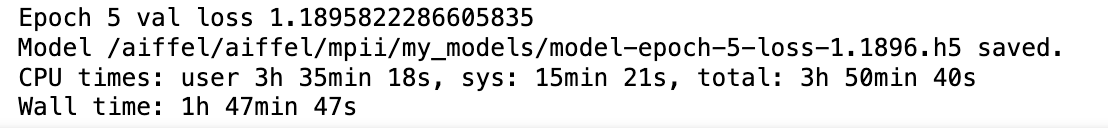
5 에폭에 1시간 47분 소요

In [30]:
# history_stackedhourglass는 "train_loss", "val_loss"만을 담고 있는 딕셔너리 임

*** SIGSEGV received at time=1721362453 on cpu 3 ***
PC: @     0x783c1c21f855  (unknown)  nsync::nsync_dll_splice_after_()
    @     0x783c867f03c0       1488  (unknown)
    @     0x783c1c21f87b         32  nsync::nsync_dll_make_first_in_list_()
    @     0x783c1c21f8b9         32  nsync::nsync_dll_make_last_in_list_()
    @     0x783c1c21fad5         96  nsync::nsync_mu_lock_slow_()
    @     0x783c1c21fb6d         32  nsync::nsync_mu_lock()
    @     0x783c0ff14114         80  TF_NewOperation
    @     0x783c097db198        192  pybind11::cpp_function::initialize<>()::{lambda()#3}::_FUN()
    @     0x783c097d1cf0        544  pybind11::cpp_function::dispatcher()
    @     0x574d65837995  (unknown)  cfunction_call
    @     0x574da7ca7400  (unknown)  (unknown)
[2024-07-19 04:14:14,362 E 65 252] logging.cc:315: *** SIGSEGV received at time=1721362454 on cpu 3 ***
[2024-07-19 04:14:14,362 E 65 252] logging.cc:315: PC: @     0x783c1c21f855  (unknown)  nsync::nsync_dll_splice_after_()
[202

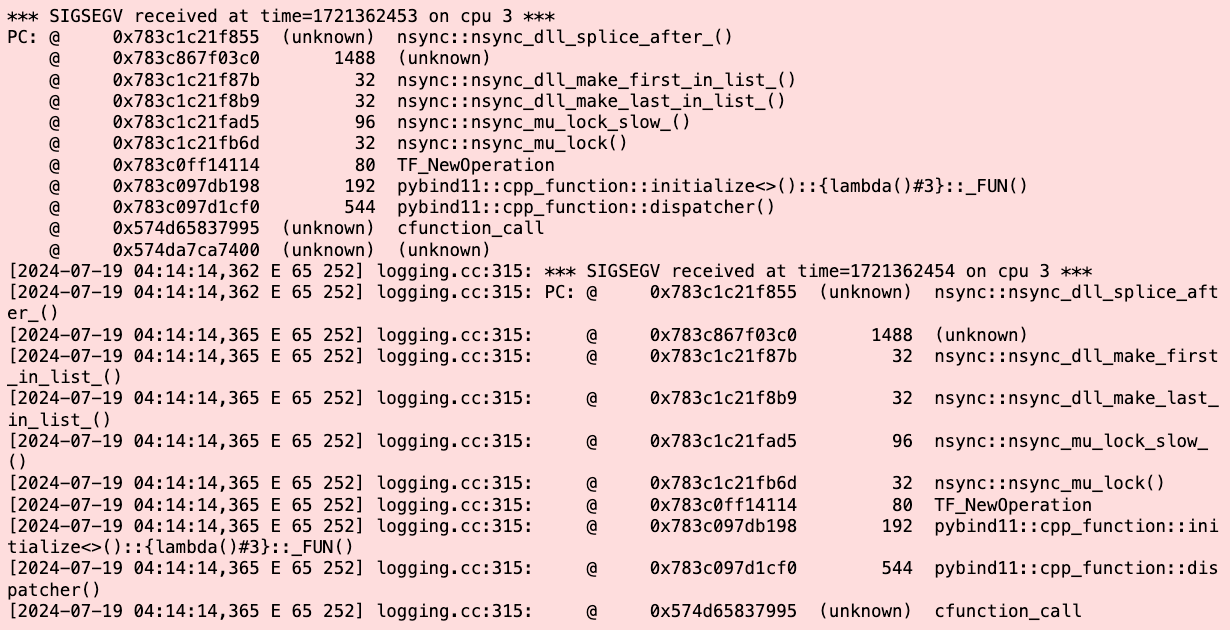

In [12]:
def plot_history(history, model_name):
    import matplotlib.ticker as ticker
    
    plt.subplots(figsize=(12,4))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(epochs, history['train_loss'], 'r')
    plt.plot(epochs, history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper left')
    
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    plt.tight_layout()
    plt.savefig(MODEL_PATH+f'/{model_name}_Result.png')  # 저장
    plt.show()

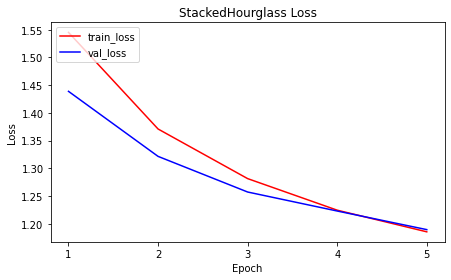

In [56]:
plot_history(history_stackedhourglass, "StackedHourglass")

- loss의 수렴을 확인

In [15]:
import pandas as pd

# history결과를 저장
def save_history(history, model_name, epochs):
    # DataFrame으로 변환
    df = pd.DataFrame(history)
    fig_name = MODEL_PATH + '/{}_model_{}_epochs.csv'.format(model_name, epochs)
    df.to_csv(fig_name)

In [16]:
save_history(history_stackedhourglass, "StackedHourglass", epochs)

NameError: name 'history_stackedhourglass' is not defined

## 둠칫둠칫 댄스타임  
학습이 끝난 모델의 inference 파이프라인을 구축해봅시다.

In [15]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 2
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'my_models', 
                            'model-epoch-5-loss-1.1896.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)


In [16]:
model.summary()

Model: "stacked_hourglass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 128, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________________

Total params: 16,368,320
Trainable params: 16,290,752
Non-trainable params: 77,568
__________________________________________________________________________________________________


In [17]:
# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
# model.load_weights(best_model_file)
# best_model_file

In [18]:
# keypoint 상수 지정
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


In [19]:
# 좌표를 히트맵으로 바꿨음 -> 히트맵의 최댓값을 좌표로 추출하는 함수
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


In [20]:
# 3x3 필터를 이용하여 근사치를 계산
# 256x256 -> 64x64의 heatmap max값 표현에 따른 quantization오차 발생을 줄이기 위함
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')


슝=3


In [21]:
# 모델, 이미지 입력 시 이미지와 keypoint를 출력하는 함수
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


In [22]:
# keypoint를 그려주는 함수
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

In [23]:
# 뼈대를 그려주는 함수
def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


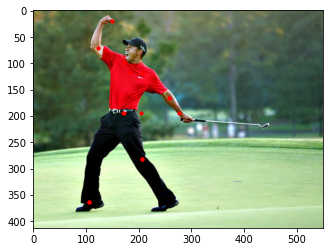

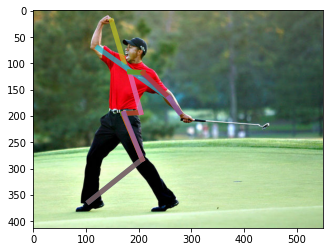

In [23]:
# 테스트 이미지를 이용하여 모델의 성능 확인하는 테스트 코드
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# Project

## 루브릭

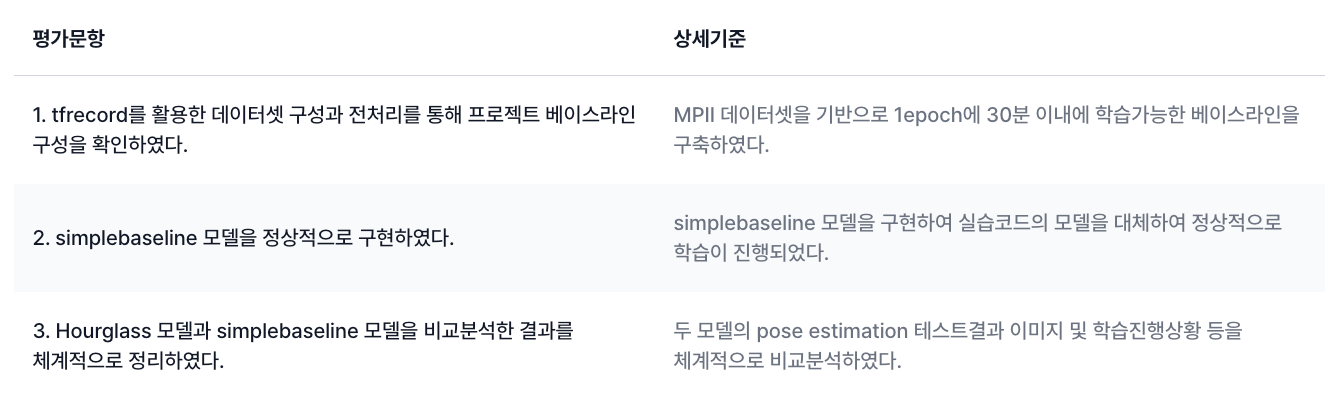

## Step 1 : simplebaseline 모델 완성하기
- simplebaseline.py 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성합니다.


### Simplebaseline 모델 생성하기
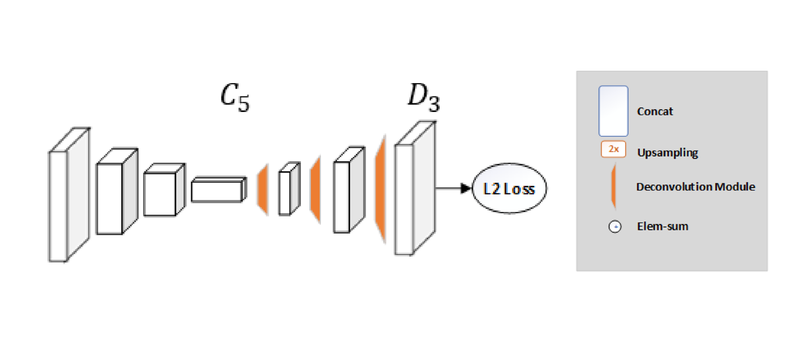

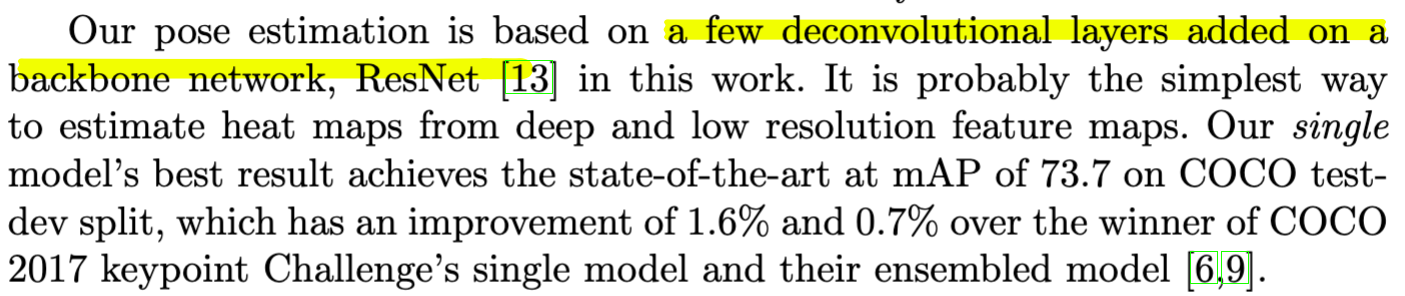

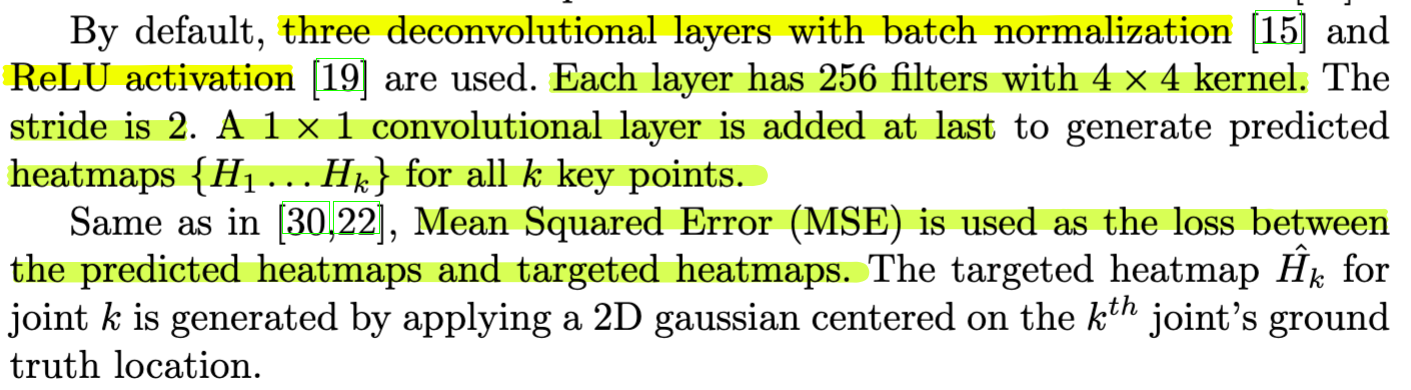

> ResNet Backbone에 deconvolution을 붙인 것

### Simplebaseline 모델 구현

In [24]:
# 참고자료: https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/models/pose_resnet.py#L144
import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization

resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

def _make_deconv_layer(num_deconv_layers,
                      filters=256,
                      kernel=4,
                       strides=(2,2),
                      ):
    seq_model = tf.keras.models.Sequential()
    
    for i in range(num_deconv_layers):
        # 256 filters with 4x4 kernel, stride 2
        seq_model.add(Conv2DTranspose(filters, kernel,
                                      strides=strides,
                                      kernel_initializer='he_normal',
                                      padding='same'))
        seq_model.add(BatchNormalization(momentum=0.9))
        seq_model.add(ReLU())         
    
    return seq_model

In [25]:
upconv = _make_deconv_layer(3)

In [26]:
# 1x1 conv layer to generate k keypoints : k = 16 by reference
# https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml
final_layer = Conv2D(
            filters=16,
            kernel_size=(1,1),
            padding='same',
            kernel_initializer='he_normal')


def Simplebaseline(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    backbone = resnet(inputs)
    after_deconv = upconv(backbone)
    out = final_layer(after_deconv)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

In [27]:
simple_model = Simplebaseline()
simple_model.summary()

Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


## Step 2 : simplebaseline 모델로 변경하여 훈련하기
- StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행합니다.

- 함수의 일부를 변형

In [28]:
simple_model.name # model의 경로에 활용하기 위한 이름확인

'simple_baseline'

In [29]:
# 수정
def train(epochs, learning_rate, num_heatmap, batch_size, 
          train_tfrecords, val_tfrecords, is_Hourglass=True):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope(): # 분산학습에서의 필요한 것
        # 분산된 데이터셋에 대한 연결 : experimental_distribute_dataset
        train_dist_dataset = strategy.experimental_distribute_dataset( 
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)
        if is_Hourglass : 
            model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        else : 
            model = Simplebaseline(IMAGE_SHAPE)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3


In [30]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0.
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1

#             if labels.shape != output.shape:
#                 raise ValueError(f"Shape mismatch: labels shape {labels.shape} and output shape {output.shape} must be the same.")
#             if labels.shape != weights.shape:
#                 raise ValueError(f"Shape mismatch: labels shape {labels.shape} and weights shape {weights.shape} must be the same.")
            
#             # Check for NaN or Inf values in labels and output
#             tf.debugging.check_numerics(labels, message="Labels contain NaN or Inf values")
#             tf.debugging.check_numerics(output, message="Output contains NaN or Inf values")
#             tf.debugging.check_numerics(weights, message="Weights contain NaN or Inf values")
        
#             a = tf.math.reduce_mean(
#                 tf.math.square(labels - output) * weights) * (
#                     1. / self.global_batch_size)
#             print(a) 
        
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)

            # for troubleshooting
#             print(labels, outputs)
            
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches
        
        # ------loss를 반환하기 위해 딕셔너리를 정의------
        history = {
            "train_loss": [],
            "val_loss": [],
        }
        
        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)

            # train_loss for each epoch
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)

            # val_loss for each epoch
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss
            
            # ------해당 에폭의 loss를 저장합니다.------
            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)
            
        return self.best_model, history


    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/{}-model-epoch-{}-loss-{:.4f}.h5'.format(self.model.name, # model name을 고려한 저장
                                                                             epoch, loss) 
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


In [31]:
%%time
tf.keras.backend.clear_session()

train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')

# Constants for hyperparameters
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_simplebaseline_model_file, history_simplebaseline = train(
    epochs, learning_rate, num_heatmap, batch_size, 
    train_tfrecords, val_tfrecords, is_Hourglass=False)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.0007


/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


INFO:tensorflow:Error reported to Coordinator: in user code:

    /tmp/ipykernel_1086/1861460295.py:77 train_step  *
        self.optimizer.apply_gradients(
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:628 apply_gradients  **
        self._create_all_weights(var_list)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:815 _create_all_weights
        self._create_slots(var_list)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:117 _create_slots
        self.add_slot(var, 'm')
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:892 add_slot
        raise ValueError(

    ValueError: Trying to create optimizer slot variable under the scope for tf.distribute.Strategy (<tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x79a5a41cda90>), which is different from the scope used for the original variable (<tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=

ValueError: in user code:

    /tmp/ipykernel_1086/1861460295.py:95 distributed_train_epoch  *
        per_replica_loss = self.strategy.run(
    /tmp/ipykernel_1086/1861460295.py:77 train_step  *
        self.optimizer.apply_gradients(
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:628 apply_gradients  **
        self._create_all_weights(var_list)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:815 _create_all_weights
        self._create_slots(var_list)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:117 _create_slots
        self.add_slot(var, 'm')
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:892 add_slot
        raise ValueError(

    ValueError: Trying to create optimizer slot variable under the scope for tf.distribute.Strategy (<tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x79a5a41cda90>), which is different from the scope used for the original variable (<tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
    array([[[[ 2.82526277e-02, -1.18737184e-02,  1.51488732e-03, ...,
              -1.07003953e-02, -5.27982824e-02, -1.36667420e-03],
             [ 5.86827798e-03,  5.04415408e-02,  3.46324709e-03, ...,
               1.01423981e-02,  1.39493728e-02,  1.67549420e-02],
             [-2.44090753e-03, -4.86173332e-02,  2.69966386e-03, ...,
              -3.44439060e-04,  3.48098315e-02,  6.28910400e-03]],
    
            [[ 1.81872323e-02, -7.20698107e-03,  4.80302610e-03, ...,
              -7.43396254e-03, -8.56800564e-03,  1.16849300e-02],
             [ 1.87554304e-02,  5.12730293e-02,  4.50406177e-03, ...,
               1.39413681e-02,  1.26296384e-02, -1.73004344e-02],
             [ 1.90453827e-02, -3.87909152e-02,  4.25842637e-03, ...,
               2.75742816e-04, -1.27962548e-02, -8.35626759e-03]],
    
            [[ 1.58849321e-02, -1.06073255e-02,  1.30999666e-02, ...,
              -2.26797583e-03, -3.98984266e-04,  3.39989027e-04],
             [ 3.61421369e-02,  5.02430499e-02,  1.22699486e-02, ...,
               1.19910473e-02,  2.02837810e-02, -1.96981970e-02],
             [ 2.17959806e-02, -3.86004597e-02,  1.12379901e-02, ...,
              -2.07756506e-03, -3.40645364e-03, -3.78638096e-02]],
    
            ...,
    
            [[-5.30153252e-02, -8.60502943e-03,  6.38643000e-03, ...,
              -4.49256925e-03,  3.48024699e-03, -1.40979560e-02],
             [-9.35578942e-02,  4.61557060e-02,  1.53722311e-03, ...,
               1.21013075e-02,  5.05337631e-03,  3.30474339e-02],
             [-7.69589692e-02, -3.51354294e-02,  2.22769519e-03, ...,
               9.18304977e-06, -1.15465783e-02,  2.29630154e-02]],
    
            [[-4.73558307e-02, -4.07940615e-03,  4.76515992e-03, ...,
              -9.73805040e-03, -1.03890402e-02,  1.62366014e-02],
             [-1.24100089e-01,  4.78516519e-02, -9.90210217e-04, ...,
               1.10340826e-02, -6.77202828e-03,  5.49102016e-02],
             [-7.13113099e-02, -2.86470409e-02,  6.20829698e-04, ...,
              -2.17762636e-03, -1.58942658e-02,  3.44766974e-02]],
    
            [[ 1.85429510e-02, -1.12518407e-02,  1.12506151e-02, ...,
              -1.51338596e-02, -5.66656142e-03, -1.30050071e-02],
             [-2.68079005e-02,  3.64737920e-02,  4.55197273e-03, ...,
               5.53486776e-03,  1.12653999e-02,  2.46754289e-03],
             [ 1.43940765e-02, -3.56382579e-02,  5.08728763e-03, ...,
              -7.46753719e-03,  1.61169283e-02,  1.12382937e-02]]],
    
    
           [[[ 7.99009297e-03, -9.49061289e-03, -4.21846565e-03, ...,
              -1.23715792e-02, -3.82804796e-02, -5.90979494e-03],
             [-7.68794632e-03,  5.46954982e-02, -1.03303632e-02, ...,
               1.40626412e-02,  1.99436247e-02,  2.51518637e-02],
             [ 3.70471564e-04, -3.70203964e-02, -9.80611611e-03, ...,
              -4.95379185e-03,  2.27415562e-02,  1.38941938e-02]],
    
            [[ 2.48856675e-02, -9.57963988e-03, -2.37837038e-03, ...,
              -1.08526833e-02,  2.24138368e-02, -2.40965877e-02],
             [ 2.42966190e-02,  4.93442900e-02, -1.32921906e-02, ...,
               1.47738317e-02,  2.67323572e-02,  1.14357602e-02],
             [ 2.91274227e-02, -3.05654686e-02, -1.42364930e-02, ...,
              -8.36174563e-03, -3.00847553e-02, -2.51545687e-03]],
    
            [[ 7.67260045e-02, -1.19650066e-02, -2.10191216e-03, ...,
               1.79589365e-03,  2.02653632e-02, -1.33340694e-02],
             [ 1.49444759e-01,  5.00719361e-02, -1.52172269e-02, ...,
               1.83409695e-02,  1.56401172e-02,  8.53796005e-02],
             [ 1.17180273e-01, -2.56576538e-02, -1.85890812e-02, ...,
              -2.50462536e-03, -5.22738546e-02,  1.17943510e-02]],
    
            ...,
    
            [[-1.89151186e-02, -1.06457584e-02, -1.19606184e-03, ...,
              -7.13960640e-03,  7.56816342e-02,  8.62411484e-02],
             [ 1.33888470e-02,  4.24321182e-02, -1.93305630e-02, ...,
               8.93499516e-03,  3.26688178e-02,  1.71118364e-01],
             [-9.38678440e-03, -2.88689751e-02, -1.87061988e-02, ...,
              -1.06920488e-02, -4.56195511e-02,  1.51734307e-01]],
    
            [[-7.93561861e-02, -8.69292021e-03,  1.06180850e-02, ...,
              -8.22936464e-03,  5.34521677e-02,  2.43676770e-02],
             [-1.76872283e-01,  4.03351039e-02, -6.91946782e-03, ...,
               1.14902109e-02,  2.45164465e-02,  1.30252065e-02],
             [-1.30214587e-01, -2.94868350e-02, -1.32359739e-03, ...,
              -8.08166154e-03, -3.32693383e-02,  1.78283844e-02]],
    
            [[-1.53617216e-02, -1.02823023e-02,  1.44553250e-02, ...,
              -1.23689836e-02,  2.81683691e-02, -1.52645903e-02],
             [-1.22947149e-01,  3.72432098e-02, -2.82740779e-03, ...,
               1.07275983e-02,  1.61965452e-02, -4.08420824e-02],
             [-7.92325959e-02, -3.09139602e-02,  1.91061670e-04, ...,
              -1.06926244e-02, -1.36199640e-02, -2.90216487e-02]]],
    
    
           [[[-2.74732877e-02, -1.59629062e-02,  5.87167032e-03, ...,
              -1.18064405e-02, -5.19699305e-02, -1.52737210e-02],
             [-7.46604949e-02,  5.22083789e-02, -1.98963331e-03, ...,
               1.27452025e-02,  7.53643783e-03, -1.96208209e-02],
             [-3.34048420e-02, -3.39833461e-02, -1.99538236e-03, ...,
              -9.30251833e-03,  3.30174603e-02, -1.65446047e-02]],
    
            [[-6.57535121e-02, -1.23513499e-02, -4.16519074e-03, ...,
              -1.22041989e-03,  2.09396798e-02,  3.62350084e-02],
             [-1.52494013e-01,  4.94739972e-02, -1.83443855e-02, ...,
               2.37025358e-02,  2.67230812e-02,  8.47681686e-02],
             [-8.80744159e-02, -2.57136654e-02, -2.17252262e-02, ...,
              -3.12197860e-03, -2.06513535e-02,  6.63726628e-02]],
    
            [[ 1.99921392e-02, -1.76080931e-02,  1.81755237e-03, ...,
               3.69562432e-02,  3.51557694e-02,  1.03931516e-01],
             [ 6.10242449e-02,  4.46803048e-02, -1.41719123e-02, ...,
               5.15808910e-02,  2.07974892e-02,  1.46060020e-01],
             [ 8.05315524e-02, -2.88072433e-02, -1.85981095e-02, ...,
               2.20173039e-02, -5.11762947e-02,  1.40093669e-01]],
    
            ...,
    
            [[ 1.15528561e-01, -1.67486407e-02,  8.49904679e-03, ...,
               4.99674492e-03,  7.98972845e-02, -1.11083500e-01],
             [ 3.32334489e-01,  4.24566194e-02, -9.70878359e-03, ...,
               1.92873720e-02,  1.25060824e-03, -3.40990961e-01],
             [ 2.16480315e-01, -2.68480480e-02, -8.96557700e-03, ...,
              -6.44540135e-03, -7.85448179e-02, -2.04899684e-01]],
    
            [[-8.99803787e-02, -8.51823762e-03,  2.25046948e-02, ...,
              -8.74274992e-04,  6.35959804e-02, -9.58404392e-02],
             [-8.15074593e-02,  4.37885672e-02,  3.69152403e-03, ...,
               1.71142723e-02,  6.33937493e-03, -2.73919165e-01],
             [-9.73245725e-02, -2.61962153e-02,  8.95403326e-03, ...,
              -7.23934872e-03, -5.64266555e-02, -1.84837982e-01]],
    
            [[-9.46454927e-02, -1.17739988e-02,  2.49665454e-02, ...,
              -7.38179125e-03,  3.05740479e-02, -1.17530329e-02],
             [-2.11111471e-01,  3.85808311e-02,  5.31885307e-03, ...,
               1.61544569e-02,  3.10361455e-03, -8.36645439e-02],
             [-1.75075874e-01, -3.21811885e-02,  9.45197884e-03, ...,
              -1.05473688e-02, -2.80730613e-02, -6.67640790e-02]]],
    
    
           ...,
    
    
           [[[ 2.31804699e-02, -1.62718501e-02,  1.22078890e-02, ...,
              -1.22131845e-02, -2.02786643e-02, -2.14508991e-03],
             [ 2.30488200e-02,  4.41800952e-02,  3.59291583e-03, ...,
               1.27932075e-02,  6.47032401e-03, -5.39429188e-02],
             [ 2.03978457e-02, -2.67958529e-02,  5.69844292e-03, ...,
              -8.20858125e-03,  2.51460597e-02, -3.12512405e-02]],
    
            [[-4.64516319e-02, -1.34653188e-02,  1.61393601e-02, ...,
              -2.20572166e-02,  5.05596139e-02,  1.47165358e-03],
             [-1.77852944e-01,  4.04180661e-02,  4.32515051e-03, ...,
               7.27979047e-03,  1.37663782e-02, -5.00506982e-02],
             [-1.09063022e-01, -2.11244933e-02,  6.98045455e-03, ...,
              -2.00869981e-02, -6.30094185e-02, -4.20499854e-02]],
    
            [[-1.83006614e-01, -1.79655701e-02,  1.82811301e-02, ...,
               1.56401389e-03,  9.29453745e-02,  4.12672907e-02],
             [-4.11783189e-01,  3.40776965e-02,  8.74394365e-03, ...,
               2.33494844e-02,  1.98237225e-02,  8.06325078e-02],
             [-2.76736170e-01, -2.83147153e-02,  1.31541817e-02, ...,
              -5.05925808e-03, -8.54580775e-02,  4.26753834e-02]],
    
            ...,
    
            [[ 5.36167026e-02, -1.07590063e-02,  2.19804980e-02, ...,
              -8.83348845e-03,  1.40453711e-01,  3.20528477e-01],
             [ 1.85792699e-01,  3.76442447e-02,  1.02089429e-02, ...,
               1.29263047e-02, -3.70457745e-03,  6.66479290e-01],
             [ 1.32038444e-01, -2.75047179e-02,  2.28339490e-02, ...,
              -1.19996015e-02, -1.22367747e-01,  4.83815670e-01]],
    
            [[ 8.34956467e-02, -9.09057911e-03,  2.50242520e-02, ...,
              -1.67011786e-02,  1.20522320e-01,  1.36462688e-01],
             [ 2.50555605e-01,  4.07686047e-02,  1.08884834e-02, ...,
               7.53540406e-03, -7.55708572e-03,  3.96415204e-01],
             [ 1.49690762e-01, -3.11034787e-02,  2.43526250e-02, ...,
              -1.65321939e-02, -1.09688722e-01,  2.64446586e-01]],
    
            [[ 3.69576029e-02, -1.27014471e-02,  3.19833457e-02, ...,
              -1.48784053e-02,  9.22970548e-02,  6.54868260e-02],
             [ 9.63706747e-02,  4.39107306e-02,  1.59802549e-02, ...,
               1.22494521e-02,  8.10312852e-03,  1.78935930e-01],
             [ 2.95156911e-02, -2.96487771e-02,  2.69996542e-02, ...,
              -1.38547905e-02, -7.72434175e-02,  1.32773802e-01]]],
    
    
           [[[ 4.22548056e-02, -8.30464344e-03,  5.34065207e-03, ...,
              -8.06468353e-03, -4.70053628e-02,  4.45614867e-02],
             [ 9.77012664e-02,  3.83502319e-02, -5.37837343e-03, ...,
               1.17106764e-02, -4.59602941e-03,  6.98771998e-02],
             [ 6.38262108e-02, -2.08319575e-02, -1.72756368e-03, ...,
              -8.19445588e-03,  4.25621867e-02,  4.83920909e-02]],
    
            [[ 4.59470600e-02, -4.77699284e-03,  7.04339007e-03, ...,
              -1.82104297e-02,  3.14848162e-02,  4.64068204e-02],
             [ 3.89483608e-02,  3.78783308e-02, -6.85291924e-03, ...,
               7.33014196e-03,  3.90656322e-04,  1.52848229e-01],
             [ 4.57218140e-02, -1.34090437e-02, -8.30697361e-04, ...,
              -1.85202472e-02, -3.45353335e-02,  9.25581828e-02]],
    
            [[-4.66161780e-02, -1.22223441e-02,  9.35023464e-03, ...,
              -1.31351836e-02,  6.08736612e-02,  9.18865502e-02],
             [-1.92336142e-01,  3.18407975e-02, -1.01881009e-03, ...,
               7.55425170e-03, -8.62357323e-04,  2.88297594e-01],
             [-1.15666650e-01, -2.35320851e-02,  6.74636895e-03, ...,
              -1.94703583e-02, -5.66169359e-02,  1.95824102e-01]],
    
            ...,
    
            [[-2.10239179e-02, -9.81471874e-03,  9.81596112e-03, ...,
              -1.36731779e-02,  1.20193027e-01, -1.26708716e-01],
             [-3.72992679e-02,  3.05935629e-02, -3.00194928e-03, ...,
               8.85152724e-03, -5.07611316e-03, -6.25461042e-02],
             [ 7.84674310e-04, -2.91344281e-02,  1.12569630e-02, ...,
              -1.38232643e-02, -9.49400812e-02, -8.74437019e-02]],
    
            [[ 3.32221799e-02, -4.22911346e-03,  1.13633750e-02, ...,
              -1.41841583e-02,  9.59840789e-02, -1.23203963e-01],
             [ 9.95653942e-02,  4.03233357e-02, -4.36036801e-03, ...,
               8.42505507e-03, -1.50266392e-02, -1.58158958e-01],
             [ 6.55353814e-02, -2.76978761e-02,  1.06595978e-02, ...,
              -1.31017175e-02, -9.93799716e-02, -1.52014121e-01]],
    
            [[ 2.50522885e-02, -1.08845932e-02,  1.29567981e-02, ...,
              -1.67823900e-02,  6.55406937e-02, -3.34061496e-02],
             [ 1.00219429e-01,  4.24924381e-02, -4.06364352e-03, ...,
               8.98410939e-03, -1.98677508e-03, -9.19047296e-02],
             [ 6.97101504e-02, -3.41515057e-02,  8.97936709e-03, ...,
              -1.51484888e-02, -8.06454644e-02, -8.53376985e-02]]],
    
    
           [[[ 1.46303158e-02, -9.15218703e-03,  5.24803856e-03, ...,
              -3.63799883e-03, -5.51798902e-02, -7.19531113e-03],
             [ 6.12211153e-02,  2.67034862e-02, -4.38000960e-03, ...,
               1.38858845e-02,  1.62421225e-03,  6.91889692e-03],
             [ 1.86353922e-02, -2.39325576e-02,  5.56383107e-04, ...,
              -6.68733614e-03,  7.36468807e-02,  3.71867418e-02]],
    
            [[ 3.52302976e-02, -3.27857491e-03,  7.14091491e-03, ...,
              -9.93822515e-03,  2.38756705e-02, -2.10771449e-02],
             [ 6.34438619e-02,  3.12160589e-02, -7.72275496e-03, ...,
               1.49217555e-02,  3.86624038e-03, -1.16395289e-02],
             [ 3.35849188e-02, -1.63664240e-02, -1.32562651e-03, ...,
              -1.30512416e-02, -7.29435496e-03, -1.24825155e-02]],
    
            [[ 4.10873676e-03, -4.66612726e-03,  1.21031692e-02, ...,
              -7.87103828e-03,  5.80726229e-02, -4.19587009e-02],
             [-2.23153979e-02,  2.99241953e-02,  8.01213668e-04, ...,
               1.82199273e-02,  9.57238674e-03, -8.57376456e-02],
             [-2.01183017e-02, -1.96383689e-02,  7.32050464e-03, ...,
              -1.07293837e-02, -2.17854325e-02, -7.95444921e-02]],
    
            ...,
    
            [[-1.71692297e-02, -3.16392444e-03,  2.40169745e-03, ...,
              -9.67177004e-03,  9.26117748e-02, -1.16062798e-02],
             [-8.63026828e-02,  3.55335064e-02, -1.06153013e-02, ...,
               1.85809545e-02, -2.19932254e-02, -1.47949710e-01],
             [-6.07556999e-02, -2.66596545e-02,  1.74473948e-03, ...,
              -4.85855900e-03, -8.82942155e-02, -8.43590796e-02]],
    
            [[ 1.15142548e-02,  2.20947526e-03,  5.08834422e-03, ...,
              -1.04352133e-02,  6.78158402e-02,  4.14623357e-02],
             [ 7.41827395e-03,  4.52373996e-02, -1.10873608e-02, ...,
               1.56368576e-02, -2.37460397e-02, -3.25448737e-02],
             [ 7.84576032e-03, -2.45320965e-02,  5.84031455e-04, ...,
              -8.31448287e-03, -8.92601907e-02, -3.36888898e-03]],
    
            [[ 4.79146978e-03, -4.22942545e-03,  1.15078716e-02, ...,
              -2.12721284e-02,  4.96782959e-02,  2.05268860e-02],
             [ 2.75192987e-02,  4.36737053e-02, -5.71439136e-03, ...,
               9.46100149e-03, -8.58635467e-04, -1.79863740e-02],
             [ 2.71184333e-02, -3.31169143e-02,  3.97488568e-03, ...,
              -1.41424611e-02, -6.35233149e-02,  1.29984575e-03]]]],
          dtype=float32)>). Make sure the slot variables are created under the same strategy scope. This may happen if you're restoring from a checkpoint outside the scope


#### Error 
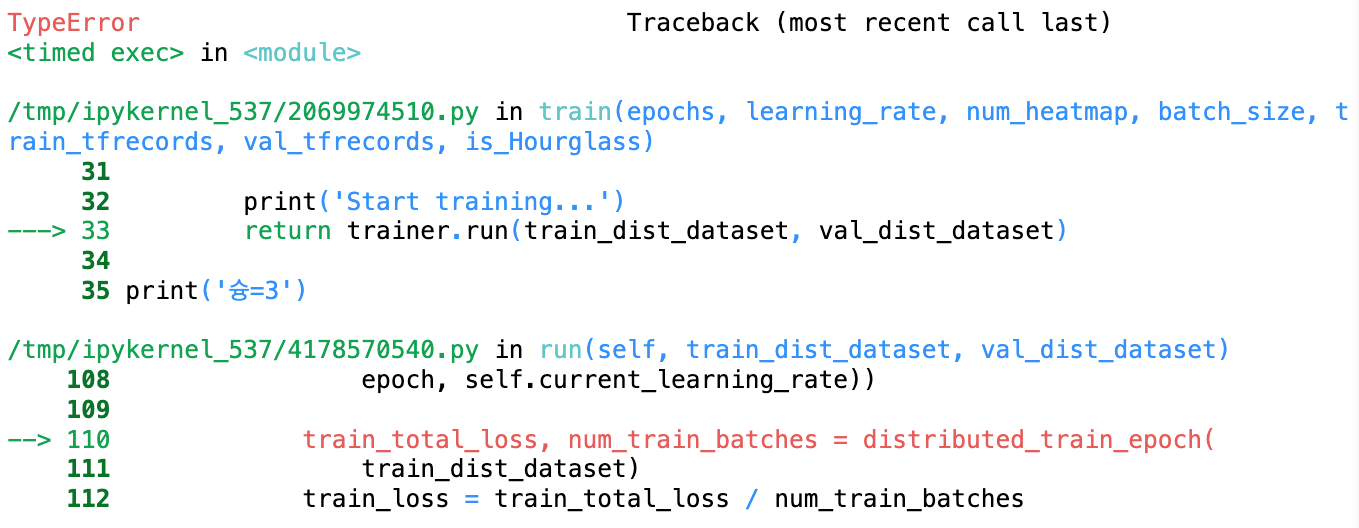
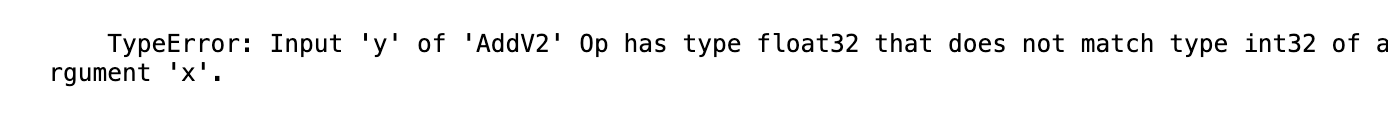

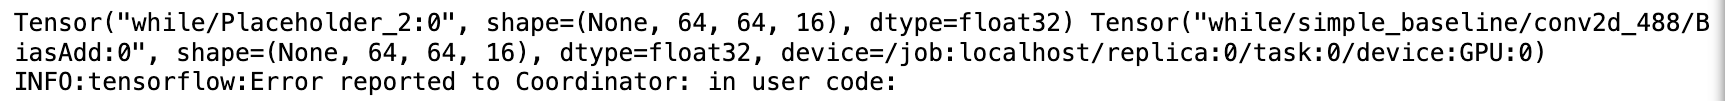

- 해당 변수 두 개(labels, outputs)에 대한 값을 찍어봤고, device가 labels의 경우 GPU에 있지 않은 것을 확인

compute_loss의 loss, outputs을 찍어봤음
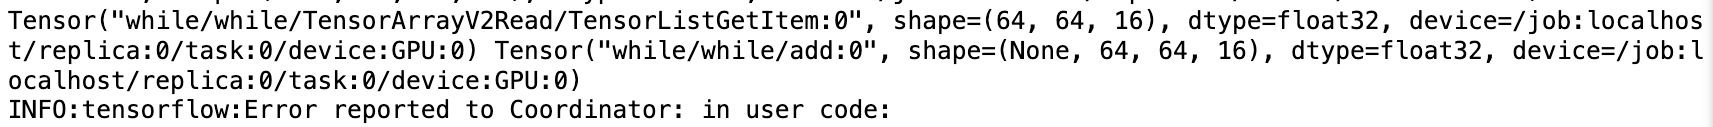

- los의 경우는 개별, outputs의 경우 Batch의 형태로 존재

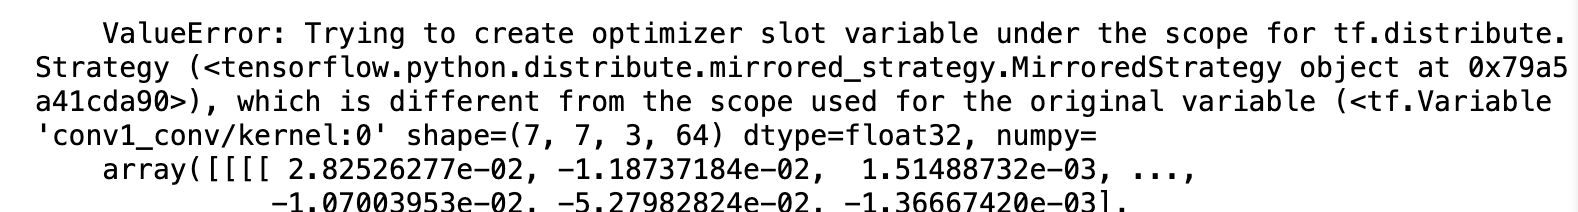

In [74]:
plot_history(history_simplebaseline, "SimpleBaseline")

NameError: name 'history_simplebaseline' is not defined

In [ ]:
save_history(history_stackedhourglass, "SimpleBaseline", epochs)

## Step 3 : 두 모델의 비교
- 실습에서 다룬 StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교해 봅니다.


### 학습 진행 경과 (loss 감소 현황)
- 가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

- 5 epoch 동안의 비교

### Pose Estimation 결과 시각화 (정성적 비교)

# 회고

- 주어진 시간 내 프로젝트를 완수하기 위해서는, 어떤 부분에서 시간이 많이 들어가는지에 대한 파악을 우선적으로 해야 함.
- 너무 고민하다가 안나오면, 이전 기수들이 진행했던 코드를 참고하면서 이해하려고 하니, 이전보다 진행률이 좋아짐.
- 결국은 내 것으로 소화해야 하는 거니까, 그냥 단순한 복사-붙여넣기는 무의미함. 
- 우선적으로 코드가 돌아가게 해 놓고, 그 이후에 코드에 대한 구성을 공부하는 식으로 전략을 변경해보니 좀 더 프로젝트에 대한 그림이 그려진다.

- 1epoch에 대한 소요시간 측정을 통해서, 두가지 모델을 돌려보았을때 예상되는 시점을 계산해보고 있으나, Simplebaseline의 경우 소요시간이 다를 수가 있기때문에 각각에 대한 테스트를 하는 것이 중요